# **iARP: Identity-Agnostic Reviewer Profiling**

* Alon Shneider

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import os
import requests
import json
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from textblob import TextBlob
import ast

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

The Data was collected from various sources (detailed in the paper), datasets, scrapped data and some data needed to be download directly from Github.
* aggregated lines loaded (excluding json files): ~1,244,415
* total json files loaded: 4765

In [ ]:
def count_json_files(directory_path):
    # Initialize counters
    total_json_files = 0
    json_file_paths = []

    # Walk through the directory and its subdirectories
    for root, dirs, files in os.walk(directory_path):
        # Count JSON files in current directory
        for file in files:
            if file.lower().endswith('.json'):
                total_json_files += 1
                json_file_paths.append(os.path.join(root, file))

    # Print the results
    print(f"Total number of JSON files found: {total_json_files}")

    # Optionally print the paths of found JSON files (first 10)
    if json_file_paths:
        print("\nSample of JSON files found:")
        for path in json_file_paths[:10]:
            print(f"- {path}")

        if len(json_file_paths) > 10:
            print(f"... and {len(json_file_paths) - 10} more files")

    return total_json_files, json_file_paths

# Example usage
directory_path = "/content/drive/MyDrive/BD PROJECT/DATA/PeerRead"  # Replace with your directory path
count_json_files(directory_path)

Total number of JSON files found: 4765

Sample of JSON files found:
- /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/173.json
- /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/352.json
- /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/37.json
- /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/371.json
- /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/489.json
- /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/660.json
- /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/94.json
- /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/148.json
- /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/323.json
- /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/355.json
... and 4755 more files


(4765,
 ['/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/173.json',
  '/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/352.json',
  '/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/37.json',
  '/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/371.json',
  '/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/489.json',
  '/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/660.json',
  '/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/94.json',
  '/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/148.json',
  '/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/323.json',
  '/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/355.json',
  '/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/435.json',
  '/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/49.json',
  '/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/496.json',
  '/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/768.json',
  '/content/drive/MyDrive/BD PROJECT/DATA/Pe

## Loading ReviewData

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('/content/drive/MyDrive/BD PROJECT/DATA/ReviewData/ReviewData-v2.sqlite3')

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:", tables)

Tables in the database: [('conferences',), ('papers',), ('reviews',), ('authors',), ('contributed',)]


In [ ]:
# Create a dictionary to store all the DataFrames
dataframes = {}

# Load each table into a pandas DataFrame
for table in tables:
    table_name = table[0]
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql_query(query, conn)
    dataframes[table_name] = df
    print(f"Loaded table '{table_name}' with {len(df)} rows and {len(df.columns)} columns")

# Close the connection
conn.close()

Loaded table 'conferences' with 10 rows and 7 columns
Loaded table 'papers' with 1627 rows and 5 columns
Loaded table 'reviews' with 4548 rows and 8 columns
Loaded table 'authors' with 6558 rows and 10 columns
Loaded table 'contributed' with 6259 rows and 2 columns


In [ ]:
conf_df = dataframes['conferences']
papers_df = dataframes['papers']
reviews_df = dataframes['reviews']
authors_df = dataframes['authors']
cont_df = dataframes['contributed']

## Loading PeerRead

Ran for all the sources

In [ ]:
def download_all_json_to_gdrive(github_url, gdrive_output_path):
    """
    Download all JSON files from a GitHub repository including subdirectories
    into a single directory in Google Drive.

    Parameters:
    github_url (str): The GitHub repository URL
    gdrive_output_path (str): Path in Google Drive to save all JSON files
    """
    # Mount Google Drive if not already mounted
    try:
        drive_already_mounted = os.path.exists('/content/drive')
        if not drive_already_mounted:
            drive.mount('/content/drive')
        print("Google Drive mounted successfully")
    except:
        print("Failed to mount Google Drive")
        return

    # Create the full path
    full_output_dir = gdrive_output_path
    os.makedirs(full_output_dir, exist_ok=True)

    # Convert github.com URLs to GitHub API format
    if "github.com" in github_url and "/tree/" in github_url:
        parts = github_url.split("/tree/")
        repo_url = parts[0].replace("github.com", "api.github.com/repos")
        branch_path = parts[1].split("/", 1)
        branch = branch_path[0]
        path = branch_path[1] if len(branch_path) > 1 else ""

        # Use GitHub API to list contents
        api_url = f"{repo_url}/contents/{path}?ref={branch}"
    else:
        print(f"Invalid GitHub URL format: {github_url}")
        return

    print(f"Using GitHub API URL: {api_url}")
    print(f"Files will be saved to: {full_output_dir}")

    # Keep track of filenames to avoid duplicates
    used_filenames = set()

    # Function to process directory contents
    def process_contents(api_url, current_path=""):
        response = requests.get(api_url)

        if response.status_code != 200:
            print(f"Failed to access {api_url}: {response.status_code}")
            return

        contents = json.loads(response.text)

        for item in contents:
            if item['type'] == 'file' and item['name'].endswith('.json'):
                # Handle filename to avoid duplicates
                base_filename = item['name']
                # Add path to filename to make it unique if needed
                if current_path and (base_filename in used_filenames):
                    # Replace slashes with underscores for a valid filename
                    path_prefix = current_path.replace('/', '_')
                    filename = f"{path_prefix}_{base_filename}"
                else:
                    filename = base_filename

                # If we still have a duplicate, add a counter
                counter = 1
                while filename in used_filenames:
                    name_parts = base_filename.rsplit('.', 1)
                    filename = f"{name_parts[0]}_{counter}.{name_parts[1]}"
                    counter += 1

                used_filenames.add(filename)

                # Download JSON file
                raw_url = item['download_url']
                local_path = os.path.join(full_output_dir, filename)

                file_response = requests.get(raw_url)
                if file_response.status_code == 200:
                    with open(local_path, 'wb') as f:
                        f.write(file_response.content)
                    print(f"Downloaded: {filename}")
                else:
                    print(f"Failed to download {raw_url}: {file_response.status_code}")

            elif item['type'] == 'dir':
                # Process subdirectory
                subdir_api_url = item['url']
                new_path = os.path.join(current_path, item['name']) if current_path else item['name']
                process_contents(subdir_api_url, new_path)

    # Start processing from the top level
    process_contents(api_url)

    total_files = len(used_filenames)
    print(f"\nAll {total_files} JSON files downloaded to {full_output_dir}")
    return full_output_dir

# Example usage
github_url = "https://github.com/allenai/PeerRead/tree/master/data/iclr_2017/train/reviews"  # Replace with your GitHub URL
gdrive_output_path = "/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/iclr_2017/"  # Replace with your Google Drive path
download_dir = download_all_json_to_gdrive(github_url, gdrive_output_path)

Google Drive mounted successfully
Using GitHub API URL: https://api.github.com/repos/allenai/PeerRead/contents/data/iclr_2017/train/reviews?ref=master
Files will be saved to: /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/iclr_2017/
Downloaded: 304.json
Downloaded: 305.json
Downloaded: 306.json
Downloaded: 307.json
Downloaded: 308.json
Downloaded: 309.json
Downloaded: 310.json
Downloaded: 312.json
Downloaded: 314.json
Downloaded: 315.json
Downloaded: 317.json
Downloaded: 318.json
Downloaded: 319.json
Downloaded: 320.json
Downloaded: 321.json
Downloaded: 322.json
Downloaded: 324.json
Downloaded: 329.json
Downloaded: 331.json
Downloaded: 332.json
Downloaded: 334.json
Downloaded: 335.json
Downloaded: 336.json
Downloaded: 338.json
Downloaded: 339.json
Downloaded: 341.json
Downloaded: 342.json
Downloaded: 343.json
Downloaded: 344.json
Downloaded: 345.json
Downloaded: 348.json
Downloaded: 349.json
Downloaded: 351.json
Downloaded: 353.json
Downloaded: 354.json
Downloaded: 357.json
Downloaded

## Loading OpenReview

In [ ]:
OR_1 = "/content/drive/MyDrive/BD PROJECT/DATA/OpenReview/train-00000-of-00002.parquet"
OR_2 = "/content/drive/MyDrive/BD PROJECT/DATA/OpenReview/train-00001-of-00002.parquet"
OR_3 = "/content/drive/MyDrive/BD PROJECT/DATA/OpenReview/forum/train-00000-of-00006.parquet"
OR_4 = "/content/drive/MyDrive/BD PROJECT/DATA/OpenReview/forum/train-00001-of-00006.parquet"
OR_5 = "/content/drive/MyDrive/BD PROJECT/DATA/OpenReview/forum/train-00002-of-00006.parquet"
OR_6 = "/content/drive/MyDrive/BD PROJECT/DATA/OpenReview/forum/train-00003-of-00006.parquet"
OR_7 = "/content/drive/MyDrive/BD PROJECT/DATA/OpenReview/forum/train-00004-of-00006.parquet"
OR_8 = "/content/drive/MyDrive/BD PROJECT/DATA/OpenReview/forum/train-00005-of-00006.parquet"

In [ ]:
# Load all DataFrames
or_df1 = pd.read_parquet(OR_1)  # Main OpenReview dataset part 1
or_df2 = pd.read_parquet(OR_2)  # Main OpenReview dataset part 2
or_df3 = pd.read_parquet(OR_3)  # Forum dataset part 1
or_df4 = pd.read_parquet(OR_4)  # Forum dataset part 2
or_df5 = pd.read_parquet(OR_5)  # Forum dataset part 3
or_df6 = pd.read_parquet(OR_6)  # Forum dataset part 4
or_df7 = pd.read_parquet(OR_7)  # Forum dataset part 5
or_df8 = pd.read_parquet(OR_8)  # Forum dataset part 6

## Loading PeerConf

In [ ]:
PeerConf = pd.read_csv('/content/drive/MyDrive/BD PROJECT/DATA/PeerConf/PeerConf - A dataset for peer review aggregation-wTktnN.csv')
PeerConf

,Conference,Paper ID,Final Decision,Peer Review,Recommendation Score,Confidence Score
0,1,1,reject,1. The paper lacks in terms of language and g...,0,4
1,1,1,reject,Please address the following aspects in order...,1,5
2,1,1,reject,The paper does not provide any thing to the b...,-2,4
3,1,1,reject,The paper provides no proper review of AI app...,-3,4
4,1,2,reject,Please address the following aspects in order...,0,4
...,...,...,...,...,...,...
3237,5,215,accept,Condition of Acceptance:1. Please follow the ...,1,4
3238,5,216,accept,The main weakness of the paper is poor resear...,0,3
3239,5,216,accept,This is a concept paper. As a non-expert of t...,0,3
3240,5,217,accept,The work presented here is really a good cont...,3,4


## Loading Publons

In [ ]:
publons = pd.read_excel('/content/drive/MyDrive/BD PROJECT/DATA/Publons/publons_review_length_data_20180305.xlsx')

# EDA

In [ ]:
def analyze_dataframe(df, name="DataFrame"):
    """
    Prints detailed information about a pandas DataFrame including NaN values analysis.

    Parameters:
    df (pandas.DataFrame): The DataFrame to analyze
    name (str): Name for the DataFrame in the output
    """
    # Basic DataFrame info
    print(f"\n{'='*50}")
    print(f"ANALYSIS OF {name.upper()}")
    print(f"{'='*50}")

    # Shape
    print(f"\nShape: {df.shape} (rows, columns)")

    # Data types
    print("\nData Types:")
    for col, dtype in df.dtypes.items():
        print(f"  {col}: {dtype}")

    # NaN analysis
    nan_counts = df.isna().sum()
    nan_percentages = (df.isna().sum() / len(df) * 100).round(2)

    print("\nNaN Analysis:")
    print(f"  Total NaN values: {df.isna().sum().sum()}")
    print(f"  Percentage of all cells with NaN: {(df.isna().sum().sum() / (df.size) * 100).round(2)}%")

    # Columns with NaN values
    nan_cols = nan_counts[nan_counts > 0]
    if len(nan_cols) > 0:
        print("\nColumns with NaN values:")
        for col, count in nan_cols.items():
            print(f"  {col}: {count} NaNs ({nan_percentages[col]}%)")
    else:
        print("\nNo columns contain NaN values")

    # Rows with NaN analysis
    rows_with_nan = df.isna().any(axis=1).sum()
    print(f"\nRows with at least one NaN: {rows_with_nan} ({(rows_with_nan / len(df) * 100).round(2)}%)")

    # Descriptive statistics for numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns
    if len(numeric_cols) > 0:
        print("\nNumeric Columns Summary Statistics:")
        print(df[numeric_cols].describe().round(2))

    # Sample of the data
    print("\nSample of the data (first 5 rows):")
    print(df.head())

    # Memory usage
    print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / (1024*1024):.2f} MB")

# Example usage
# analyze_dataframe(dataframes['table_name'], 'table_name')

In [ ]:
def plot_column_distribution(df, column_name, top_k=20, figsize=(10, 6), kde=False):
   """
   Plot the distribution of values in a specific column of a DataFrame.

   Args:
       df: pandas DataFrame
       column_name: str, name of the column to plot
       top_k: int, number of top values to display for categorical data
       figsize: tuple, figure size in inches (width, height)
       kde: bool, whether to show kernel density estimation curve for numeric data
   """


   # Check if column exists
   if column_name not in df.columns:
       print(f"Column '{column_name}' not found in DataFrame!")
       return

   # Determine plot type based on data type
   is_numeric = pd.api.types.is_numeric_dtype(df[column_name])

   # Create figure
   plt.figure(figsize=figsize)

   # Plot based on data type
   if is_numeric:
       # For numeric data
       ax = sns.histplot(data=df[column_name], kde=kde)
       plt.title(f'Distribution of {column_name}')
       plt.xlabel(column_name)
       plt.ylabel('Frequency')

       # Show exact values on x-axis
       plt.xticks(rotation=45)  # Rotate labels if needed

       # Add percentage labels
       total = len(df[column_name].dropna())
       for p in ax.patches:
           height = p.get_height()
           percentage = 100 * height / total
           if percentage >= 1:  # Only show if percentage is at least 1%
               ax.text(p.get_x() + p.get_width()/2., height + 0.1,
                       f'{percentage:.1f}%', ha="center")
   else:
       # For categorical data
       # Calculate value counts and percentages
       value_counts = df[column_name].value_counts()
       total_count = len(df[column_name].dropna())

       # Get top k categories
       top_categories = value_counts.index[:top_k]
       top_counts = value_counts[:top_k]
       percentages = 100 * top_counts / total_count

       # Create plot
       ax = sns.barplot(x=percentages, y=top_categories)

       # Add percentage and count labels
       for i, (count, percentage) in enumerate(zip(top_counts, percentages)):
           ax.text(percentage + 0.5, i, f'{percentage:.1f}% ({count:,})', va='center')

       # Show exact values on x-axis
       plt.xticks(np.arange(0, max(percentages) + 5, 5))  # Show ticks every 5%

       plt.title(f'Top {top_k} values in {column_name}')
       plt.ylabel(column_name)
       plt.xlabel('Percentage')

   # Display the plot
   plt.tight_layout()
   plt.show()

   # Print basic statistics
   print(f"Statistics for {column_name}:")
   if is_numeric:
       print(df[column_name].describe())
   else:
       print(f"Total unique values: {df[column_name].nunique()}")
       print(f"Top {min(5, top_k)} values:")
       print(100 * df[column_name].value_counts()[:5] / total_count)

# Example usage:
# plot_column_distribution(or_main_df, 'your_column_name', top_k=10, kde=True)

In [ ]:
def analyze_json_file(file_path):
    """
    Reads a JSON file and prints its structure in an organized way.

    Args:
        file_path (str): Path to the JSON file
    """
    print("\n" + "="*80)
    print(f"ANALYZING JSON FILE: {os.path.basename(file_path)}")
    print("="*80)

    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Error: File '{file_path}' does not exist.")
        return

    # Read the JSON file
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
    except json.JSONDecodeError:
        print(f"Error: '{file_path}' is not a valid JSON file.")
        return
    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return

    # Print basic information
    print(f"File: {file_path}")
    print(f"Data type: {type(data).__name__}")

    # Print the keys at the top level (if it's a dictionary)
    if isinstance(data, dict):
        print("\nTop-level keys:")
        for key in data.keys():
            print(f"- {key}")

    # Print a structured overview
    print("\nStructured overview:")
    print_json_structure(data)

    # For a more comprehensive view of a specific part (if needed)
    print("\nDetailed pretty print (use for specific sections):")
    pprint.pprint(data, depth=2, width=100, compact=True)

    print("\n" + "="*80)
    return data

def print_json_structure(json_data, indent=0):
    """
    Recursively prints the structure of a JSON object with proper indentation
    """
    if isinstance(json_data, dict):
        print("Dictionary with", len(json_data), "keys:")
        for key, value in json_data.items():
            print(" " * indent + f"- Key: {key} →", end=" ")

            if isinstance(value, (dict, list)):
                print()
                print_json_structure(value, indent + 4)
            else:
                # For simple values, print them directly
                value_str = str(value)
                # Truncate long values
                if len(value_str) > 50:
                    value_str = value_str[:50] + "..."
                print(f"Value: {value_str} (Type: {type(value).__name__})")

    elif isinstance(json_data, list):
        print("List with", len(json_data), "items:")

        # For long lists, show just a sample
        if len(json_data) > 5:
            for i, item in enumerate(json_data[:3]):
                print(" " * indent + f"- Item {i}:", end=" ")
                if isinstance(item, (dict, list)):
                    print()
                    print_json_structure(item, indent + 4)
                else:
                    print(item)
            print(" " * indent + "... (more items)")
            # Show the last item
            print(" " * indent + f"- Item {len(json_data)-1}:", end=" ")
            if isinstance(json_data[-1], (dict, list)):
                print()
                print_json_structure(json_data[-1], indent + 4)
            else:
                print(json_data[-1])
        else:
            # For shorter lists, show all items
            for i, item in enumerate(json_data):
                print(" " * indent + f"- Item {i}:", end=" ")
                if isinstance(item, (dict, list)):
                    print()
                    print_json_structure(item, indent + 4)
                else:
                    print(item)
    else:
        # This should not happen at the top level if it's a valid JSON
        print(json_data)

## ReviewData

This dataset contains 5 tables: Authors, Conferences, Contributed, Papers, and Reviews.

In [ ]:
""
df = conf_df
print(df.shape)
df

(10, 7)


,cid,name,accept_count,reject_count,selectivity,is_workshop,double_blind
0,1,ICML.cc/2019/Workshop/RL4RealLife,23,9,0.281250,1,0
1,2,ICLR.cc/2019/Workshop/LLD,47,19,0.287879,1,1
2,3,eswc-conferences.org/ESWC/2019/Workshop/KGB,5,2,0.285714,1,0
3,4,NIPS.cc/2018/Workshop/MLITS,21,4,0.160000,1,0
4,5,MIDL.amsterdam/2018/Conference,53,38,0.417582,0,0
5,6,MIDL.amsterdam/2018/Abstract,30,42,0.583000,0,0
6,7,ICLR.cc/2018/Workshop,192,151,0.440200,1,0
7,8,ICLR.cc/2018/Conference,443,475,0.517429,0,1
8,9,ICLR.cc/2017/workshop,77,47,0.379000,1,0
9,10,ICLR.cc/2017/conference,260,230,0.469387,0,0


In [ ]:
df = papers_df
print(df.shape)
df.head()

(1627, 5)


,pid,title,abstract,decision,submitted_to
0,BJlk4QeajE,Reinforcement Learning and Adaptive Sampling f...,Achieving faster execution with shorter compil...,1,1
1,H1xSXdV0i4,Addressing Sample Complexity in Visual Tasks U...,Reinforcement Learning (RL) algorithms typical...,1,1
2,B1l3hfy6jN,Learning State Switching for Improved Explorat...,Reinforcement learning has been used to achiev...,0,1
3,HyeNo333jE,A Spectral Method for Off-Policy Evaluation in...,Contextual bandits capture the partial-feedbac...,0,1
4,SJlCkwN8iV,Real-world Video Adaptation with Reinforcement...,Client-side video players employ adaptive bitr...,1,1


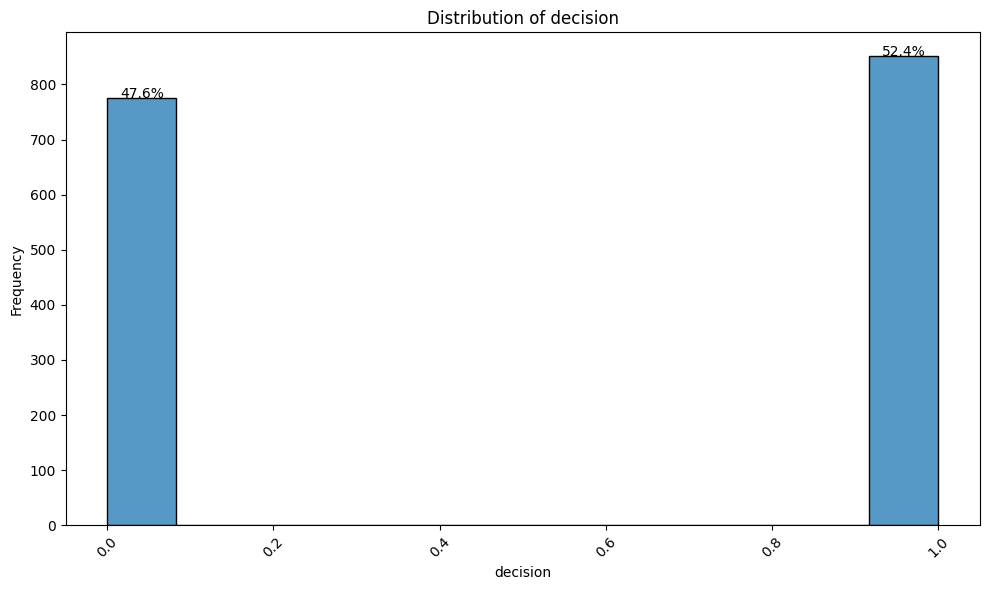

Statistics for decision:
count    1627.000000
mean        0.523663
std         0.499593
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: decision, dtype: float64


In [ ]:
plot_column_distribution(papers_df, 'decision', top_k=20, figsize=(10, 6), kde=False)

In [ ]:
df = reviews_df
print(df.shape)
df.head()

(4548, 8)


,rid,review_of,title,review,rating,confidence,raw_rating,raw_confidence
0,112,BJlk4QeajE,"sensible approach to RL for compilers, might b...",The authors describe an RL approach to speed u...,0.555556,0.25,4: Weak Accept,2: The reviewer is willing to defend the evalu...
1,113,BJlk4QeajE,Accept. Well written and evaluated. But not a ...,This paper proposes a reinforcement learning a...,0.555556,0.75,4: Weak Accept,4: The reviewer is confident but not absolutel...
2,114,H1xSXdV0i4,An extension of HER to incorporate visual task...,"In this work, the authors proposed HALGAN, a t...",0.500000,0.75,3: Borderline,4: The reviewer is confident but not absolutel...
3,115,H1xSXdV0i4,GANs to add targets to failed trajectories for...,This paper presents an approach to applying HE...,0.555556,0.75,4: Weak Accept,4: The reviewer is confident but not absolutel...
4,116,B1l3hfy6jN,An interesting application of reinforcement le...,"The paper applies reinforcement learning, in p...",0.250000,0.75,2: Weak Reject,4: The reviewer is confident but not absolutel...


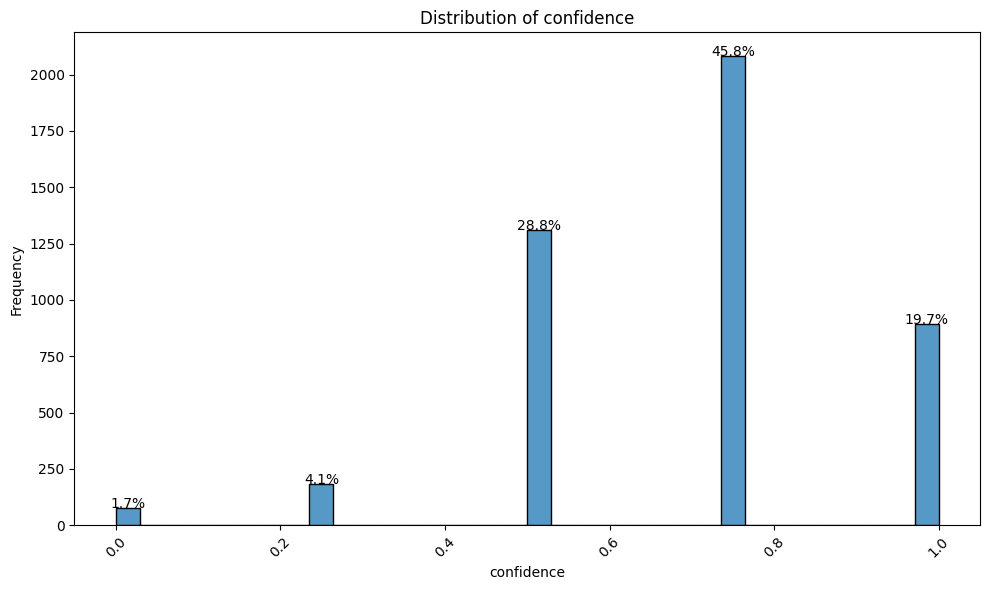

Statistics for confidence:
count    4548.000000
mean        0.694261
std         0.216496
min         0.000000
25%         0.500000
50%         0.750000
75%         0.750000
max         1.000000
Name: confidence, dtype: float64


In [ ]:
plot_column_distribution(reviews_df, 'confidence', top_k=20, figsize=(10, 6), kde=False)

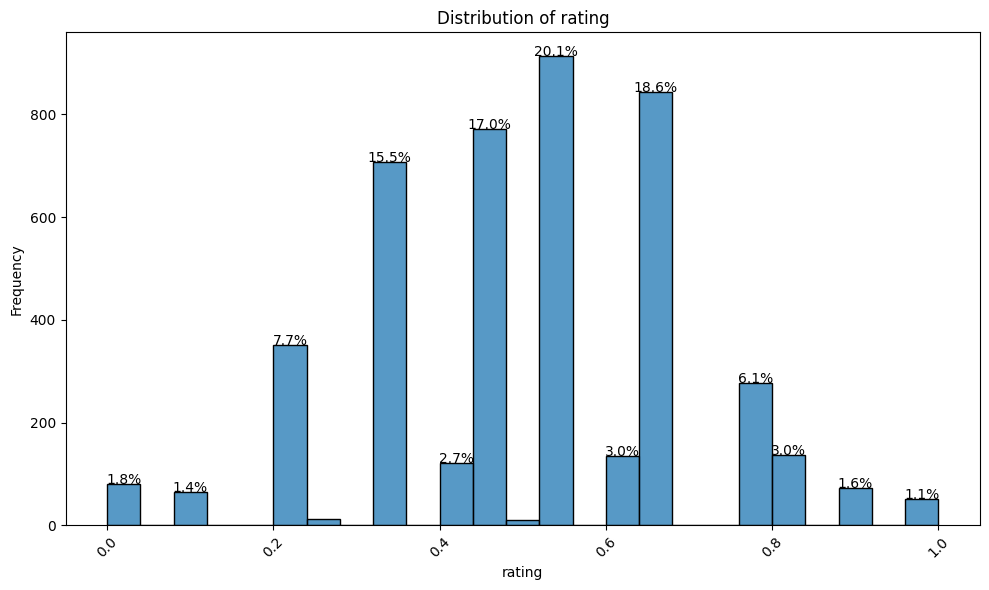

Statistics for rating:
count    4548.000000
mean        0.508534
std         0.190927
min         0.000000
25%         0.333333
50%         0.555556
75%         0.666667
max         1.000000
Name: rating, dtype: float64


In [ ]:
plot_column_distribution(reviews_df, 'rating', top_k=20, figsize=(10, 6), kde=False)

In [ ]:
df = authors_df
print(df.shape)
df.head()

(6558, 10)


,aid,name,email,inst_guess,world_rank,document_count,citation_count,h_index,coauthor_count,years_experience
0,0,Hsun-An Chiang,laba15454@gmail.com,,-,NaN,NaN,NaN,NaN,NaN
1,1,Stephen Phillips,stephi@seas.upenn.edu,University of Pennsylvania,61,31.0,811.0,14.0,55.0,34.0
2,2,Sham Kakade,sham@cs.washington.edu,"University of Washington, Seattle",54,115.0,5373.0,37.0,102.0,19.0
3,3,Douglas Eck,deck@google.com,Google LLC,101-150,64.0,1307.0,19.0,90.0,18.0
4,4,Tomas Kocisky,tkocisky@google.com,Google LLC,10,4.0,485.0,3.0,12.0,4.0


In [ ]:
df = cont_df
print(df.shape)
df.head()

(6259, 2)


,ctr_aid,ctr_pid
0,5498,BJlk4QeajE
1,681,BJlk4QeajE
2,4090,BJlk4QeajE
3,3087,H1xSXdV0i4
4,5852,H1xSXdV0i4


Let's explore those tables and examine their data:

In [ ]:
for table_name, df in dataframes.items():
    analyze_dataframe(df, table_name)


ANALYSIS OF CONFERENCES

Shape: (10, 7) (rows, columns)

Data Types:
  cid: int64
  name: object
  accept_count: int64
  reject_count: int64
  selectivity: float64
  is_workshop: int64
  double_blind: int64

NaN Analysis:
  Total NaN values: 0
  Percentage of all cells with NaN: 0.0%

No columns contain NaN values

Rows with at least one NaN: 0 (0.0%)

Numeric Columns Summary Statistics:
         cid  accept_count  reject_count  selectivity  is_workshop  \
count  10.00         10.00         10.00        10.00        10.00   
mean    5.50        115.10        101.70         0.38         0.60   
std     3.03        141.84        150.47         0.13         0.52   
min     1.00          5.00          2.00         0.16         0.00   
25%     3.25         24.75         11.50         0.29         0.00   
50%     5.50         50.00         40.00         0.40         1.00   
75%     7.75        163.25        125.00         0.46         1.00   
max    10.00        443.00        475.00        

## PeerRead

We have json files for each conference, let's check the general structure of those files in each conference and see if they all have a unified format:

In [ ]:
# READ A PEERREAD JSON FILE
# Path to your JSON file
file_path = "/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/104.json"

# Read the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Function to print JSON structure in an organized way
def print_json_structure(json_data, indent=0):
    """
    Recursively prints the structure of a JSON object with proper indentation
    """
    if isinstance(json_data, dict):
        print("Dictionary with", len(json_data), "keys:")
        for key, value in json_data.items():
            print(" " * indent + f"- Key: {key} →", end=" ")

            if isinstance(value, (dict, list)):
                print()
                print_json_structure(value, indent + 4)
            else:
                # For simple values, print them directly
                value_str = str(value)
                # Truncate long values
                if len(value_str) > 50:
                    value_str = value_str[:50] + "..."
                print(f"Value: {value_str} (Type: {type(value).__name__})")

    elif isinstance(json_data, list):
        print("List with", len(json_data), "items:")

        # For long lists, show just a sample
        if len(json_data) > 5:
            for i, item in enumerate(json_data[:3]):
                print(" " * indent + f"- Item {i}:", end=" ")
                if isinstance(item, (dict, list)):
                    print()
                    print_json_structure(item, indent + 4)
                else:
                    print(item)
            print(" " * indent + "... (more items)")
            # Show the last item
            print(" " * indent + f"- Item {len(json_data)-1}:", end=" ")
            if isinstance(json_data[-1], (dict, list)):
                print()
                print_json_structure(json_data[-1], indent + 4)
            else:
                print(json_data[-1])
        else:
            # For shorter lists, show all items
            for i, item in enumerate(json_data):
                print(" " * indent + f"- Item {i}:", end=" ")
                if isinstance(item, (dict, list)):
                    print()
                    print_json_structure(item, indent + 4)
                else:
                    print(item)
    else:
        # This should not happen at the top level if it's a valid JSON
        print(json_data)

# Print basic information
print(f"File: {file_path}")
print(f"Data type: {type(data).__name__}")

# Print the keys at the top level (if it's a dictionary)
if isinstance(data, dict):
    print("\nTop-level keys:")
    for key in data.keys():
        print(f"- {key}")

# Print a structured overview
print("\nStructured overview:")
print_json_structure(data)

# For a more comprehensive view of a specific part (if needed)
print("\nDetailed pretty print (use for specific sections):")
pprint.pprint(data, depth=2, width=100, compact=True)

File: /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/104.json
Data type: dict

Top-level keys:
- reviews
- abstract
- histories
- id
- title

Structured overview:
Dictionary with 5 keys:
- Key: reviews → 
List with 3 items:
    - Item 0: 
Dictionary with 12 keys:
        - Key: IMPACT → Value: 3 (Type: str)
        - Key: SUBSTANCE → Value: 4 (Type: str)
        - Key: APPROPRIATENESS → Value: 5 (Type: str)
        - Key: MEANINGFUL_COMPARISON → Value: 2 (Type: str)
        - Key: PRESENTATION_FORMAT → Value: Poster (Type: str)
        - Key: comments → Value: - Strengths:
* Outperforms ALIGN in supervised ent... (Type: str)
        - Key: SOUNDNESS_CORRECTNESS → Value: 4 (Type: str)
        - Key: ORIGINALITY → Value: 3 (Type: str)
        - Key: is_meta_review → Value: None (Type: NoneType)
        - Key: RECOMMENDATION → Value: 3 (Type: str)
        - Key: CLARITY → Value: 3 (Type: str)
        - Key: REVIEWER_CONFIDENCE → Value: 3 (Type: str)
    - Item 1: 
Dictionary with 1

In [ ]:
# Analyze a single JSON file from ACL17
analyze_json_file("/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/104.json")


ANALYZING JSON FILE: 104.json
File: /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17/104.json
Data type: dict

Top-level keys:
- reviews
- abstract
- histories
- id
- title

Structured overview:
Dictionary with 5 keys:
- Key: reviews → 
List with 3 items:
    - Item 0: 
Dictionary with 12 keys:
        - Key: IMPACT → Value: 3 (Type: str)
        - Key: SUBSTANCE → Value: 4 (Type: str)
        - Key: APPROPRIATENESS → Value: 5 (Type: str)
        - Key: MEANINGFUL_COMPARISON → Value: 2 (Type: str)
        - Key: PRESENTATION_FORMAT → Value: Poster (Type: str)
        - Key: comments → Value: - Strengths:
* Outperforms ALIGN in supervised ent... (Type: str)
        - Key: SOUNDNESS_CORRECTNESS → Value: 4 (Type: str)
        - Key: ORIGINALITY → Value: 3 (Type: str)
        - Key: is_meta_review → Value: None (Type: NoneType)
        - Key: RECOMMENDATION → Value: 3 (Type: str)
        - Key: CLARITY → Value: 3 (Type: str)
        - Key: REVIEWER_CONFIDENCE → Value: 3 (Type: str)
 

{'reviews': [{'IMPACT': '3',
   'SUBSTANCE': '4',
   'APPROPRIATENESS': '5',
   'MEANINGFUL_COMPARISON': '2',
   'PRESENTATION_FORMAT': 'Poster',
   'comments': '- Strengths:\n* Outperforms ALIGN in supervised entity linking task which suggests that the\nproposed framework improves representations of text and knowledge that are\nlearned jointly.\n* Direct comparison with closely related approach using very similar input\ndata.\n* Analysis of the smoothing parameter provides useful analysis since impact of\npopularity is a persistent issue in entity linking.\n\n- Weaknesses:\n* Comparison with ALIGN could be better. ALIGN used content window size 10 vs\nthis paper\'s 5, vector dimension of 500 vs this paper\'s 200. Also its not clear\nto me whether N(e_j) includes only entities that link to e_j. The graph is\ndirected and consists of wikipedia outlinks, but is adjacency defined as it\nwould be for an undirected graph? For ALIGN, the context of an entity is the\nset of entities that link

In [ ]:
# Analyze a single JSON file from arxiv cs.ai
analyze_json_file("/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/arxiv.cs.ai_2007-2017/0804.0188.json")


ANALYZING JSON FILE: 0804.0188.json
File: /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/arxiv.cs.ai_2007-2017/0804.0188.json
Data type: dict

Top-level keys:
- conference
- VERSION
- DATE_OF_SUBMISSION
- title
- abstract
- histories
- reviews
- SUBJECTS
- authors
- accepted
- id

Structured overview:
Dictionary with 11 keys:
- Key: conference → Value: NIPS (Type: str)
- Key: VERSION → Value: v1 (Type: str)
- Key: DATE_OF_SUBMISSION → Value: 1-Apr-2008 (Type: str)
- Key: title → Value: Support Vector Machine Classification with Indefin... (Type: str)
- Key: abstract → Value: We propose a method for support vector machine cla... (Type: str)
- Key: histories → 
List with 2 items:
    - Item 0: 
List with 4 items:
        - Item 0: v1
        - Item 1: Tue, 1 Apr 2008 14:55:33 GMT  (25kb)
        - Item 2: https://arxiv.org/abs/0804.0188v1
        - Item 3: None
    - Item 1: 
List with 4 items:
        - Item 0: v2
        - Item 1: Tue, 4 Aug 2009 11:48:14 GMT  (31kb)
        - Item 2

{'conference': 'NIPS',
 'VERSION': 'v1',
 'DATE_OF_SUBMISSION': '1-Apr-2008',
 'title': 'Support Vector Machine Classification with Indefinite Kernels',
 'abstract': 'We propose a method for support vector machine classification using indefinite kernels. Instead of directly minimizing or stabilizing a nonconvex loss function, our algorithm simultaneously computes support vectors and a proxy kernel matrix used in forming the loss. This can be interpreted as a penalized kernel learning problem where indefinite kernel matrices are treated as a noisy observations of a true Mercer kernel. Our formulation keeps the problem convex and relatively large problems can be solved efficiently using the projected gradient or analytic center cutting plane methods. We compare the performance of our technique with other methods on several classic data sets.',
 'histories': [['v1',
   'Tue, 1 Apr 2008 14:55:33 GMT  (25kb)',
   'https://arxiv.org/abs/0804.0188v1',
   None],
  ['v2',
   'Tue, 4 Aug 2009 11

In [ ]:
# Analyze a single JSON file from arxiv cs.cl
analyze_json_file("/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/arxiv.cs.cl_2007-2017/0801.4716.json")


ANALYZING JSON FILE: 0801.4716.json
File: /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/arxiv.cs.cl_2007-2017/0801.4716.json
Data type: dict

Top-level keys:
- conference
- VERSION
- DATE_OF_SUBMISSION
- title
- abstract
- histories
- COMMENTS
- reviews
- SUBJECTS
- authors
- accepted
- id

Structured overview:
Dictionary with 12 keys:
- Key: conference → Value: EMNLP (Type: str)
- Key: VERSION → Value: v1 (Type: str)
- Key: DATE_OF_SUBMISSION → Value: 30-Jan-2008 (Type: str)
- Key: title → Value: Methods to Integrate a Language Model with Semanti... (Type: str)
- Key: abstract → Value: Most current word prediction systems make use of n... (Type: str)
- Key: histories → 
List with 1 items:
    - Item 0: 
List with 4 items:
        - Item 0: v1
        - Item 1: Wed, 30 Jan 2008 17:10:24 GMT  (198kb)
        - Item 2: http://arxiv.org/abs/0801.4716v1
        - Item 3: 10 pages ; EMNLP'2007 Conference (Prague)
- Key: COMMENTS → Value: 10 pages ; EMNLP'2007 Conference (Prague) (Type: s

{'conference': 'EMNLP',
 'VERSION': 'v1',
 'DATE_OF_SUBMISSION': '30-Jan-2008',
 'title': 'Methods to Integrate a Language Model with Semantic Information for a Word Prediction Component',
 'abstract': 'Most current word prediction systems make use of n-gram language models (LM) to estimate the probability of the following word in a phrase. In the past years there have been many attempts to enrich such language models with further syntactic or semantic information. We want to explore the predictive powers of Latent Semantic Analysis (LSA), a method that has been shown to provide reliable information on long-distance semantic dependencies between words in a context. We present and evaluate here several methods that integrate LSA-based information with a standard language model: a semantic cache, partial reranking, and different forms of interpolation. We found that all methods show significant improvements, compared to the 4-gram baseline, and most of them to a simple cache model as wel

In [ ]:
# Analyze a single JSON file from arxiv cs.lg
analyze_json_file("/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/arxiv.cs.lg_2007-2017/0704.2668.json")


ANALYZING JSON FILE: 0704.2668.json
File: /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/arxiv.cs.lg_2007-2017/0704.2668.json
Data type: dict

Top-level keys:
- conference
- VERSION
- DATE_OF_SUBMISSION
- title
- abstract
- histories
- COMMENTS
- reviews
- SUBJECTS
- authors
- accepted
- id

Structured overview:
Dictionary with 12 keys:
- Key: conference → Value: ICML (Type: str)
- Key: VERSION → Value: v1 (Type: str)
- Key: DATE_OF_SUBMISSION → Value: 20-Apr-2007 (Type: str)
- Key: title → Value: Supervised feature selection via dependence estima... (Type: str)
- Key: abstract → Value: We introduce a framework for filtering features th... (Type: str)
- Key: histories → 
List with 1 items:
    - Item 0: 
List with 4 items:
        - Item 0: v1
        - Item 1: Fri, 20 Apr 2007 08:26:29 GMT  (373kb,D)
        - Item 2: http://arxiv.org/abs/0704.2668v1
        - Item 3: 9 pages
- Key: COMMENTS → Value: 9 pages (Type: str)
- Key: reviews → 
List with 0 items:
- Key: SUBJECTS → Value: c

{'conference': 'ICML',
 'VERSION': 'v1',
 'DATE_OF_SUBMISSION': '20-Apr-2007',
 'title': 'Supervised feature selection via dependence estimation',
 'abstract': 'We introduce a framework for filtering features that employs the Hilbert-Schmidt Independence Criterion (HSIC) as a measure of dependence between the features and the labels. The key idea is that good features should maximise such dependence. Feature selection for various supervised learning problems (including classification and regression) is unified under this framework, and the solutions can be approximated using a backward-elimination algorithm. We demonstrate the usefulness of our method on both artificial and real world datasets.',
 'histories': [['v1',
   'Fri, 20 Apr 2007 08:26:29 GMT  (373kb,D)',
   'http://arxiv.org/abs/0704.2668v1',
   '9 pages']],
 'COMMENTS': '9 pages',
 'reviews': [],
 'SUBJECTS': 'cs.LG',
 'authors': ['le song',
  'alexander j smola',
  'arthur gretton',
  'karsten m borgwardt',
  'justin bedo']

In [ ]:
# Analyze a single JSON file from conll_2016
analyze_json_file("/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/conll_2016/103.json")


ANALYZING JSON FILE: 103.json
File: /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/conll_2016/103.json
Data type: dict

Top-level keys:
- title
- abstract
- id
- reviews

Structured overview:
Dictionary with 4 keys:
- Key: title → Value: Measuring Topic Quality using Word Buckets (Type: str)
- Key: abstract → Value: Measuring topic quality is essential for scoring t... (Type: str)
- Key: id → Value: 103 (Type: str)
- Key: reviews → 
List with 2 items:
    - Item 0: 
Dictionary with 13 keys:
        - Key: comments → Value: This paper proposes a method for evaluating topic ... (Type: str)
        - Key: is_meta_review → Value: None (Type: NoneType)
        - Key: RECOMMENDATION → Value: 2 (Type: str)
        - Key: REPLICABILITY → Value: 4 (Type: str)
        - Key: PRESENTATION_FORMAT → Value: Poster (Type: str)
        - Key: CLARITY → Value: 4 (Type: str)
        - Key: MEANINGFUL_COMPARISON → Value: 5 (Type: str)
        - Key: SUBSTANCE → Value: 3 (Type: str)
        - Key: REVIE

{'title': 'Measuring Topic Quality using Word Buckets',
 'abstract': 'Measuring topic quality is essential for scoring the learned topics and their subsequent use in Information Retrieval and Text classification. To measure quality of Latent Dirichlet Allocation (LDA) based topics learned from text, we propose a novel approach based on grouping of topic words into buckets (TBuckets). A single large bucket signifies a single coherent theme, in turn indicating high topic coherence. TBuckets represents topic words using their word embeddings and employs 3 different techniques for creating buckets of words - i) clustering based, ii) using singular value decomposition (SVD) and iii) SVD with reorganization. The TBuckets approach outperforms the state-of-the-art techniques when evaluated using three publicly available datasets. Further, we demonstrate the usefulness of TBuckets for the task of weakly supervised text classification.',
 'id': '103',
 'reviews': [{'comments': "This paper propos

In [ ]:
# Analyze a single JSON file from iclr_2017
analyze_json_file("/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/iclr_2017/304.json")


ANALYZING JSON FILE: 304.json
File: /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/iclr_2017/304.json
Data type: dict

Top-level keys:
- conference
- title
- abstract
- histories
- reviews
- authors
- accepted
- id

Structured overview:
Dictionary with 8 keys:
- Key: conference → Value: ICLR 2017 conference submission (Type: str)
- Key: title → Value: Making Neural Programming Architectures Generalize... (Type: str)
- Key: abstract → Value: Empirically, neural networks that attempt to learn... (Type: str)
- Key: histories → 
List with 0 items:
- Key: reviews → 
List with 14 items:
    - Item 0: 
Dictionary with 2 keys:
        - Key: IS_META_REVIEW → Value: True (Type: bool)
        - Key: comments → Value: This paper improves significantly upon the origina... (Type: str)
    - Item 1: 
Dictionary with 5 keys:
        - Key: DATE → Value: 02 May 2017 (Type: str)
        - Key: TITLE → Value: Source code (Type: str)
        - Key: IS_META_REVIEW → Value: False (Type: bool)
        - K

{'conference': 'ICLR 2017 conference submission',
 'title': 'Making Neural Programming Architectures Generalize via Recursion',
 'abstract': 'Empirically, neural networks that attempt to learn programs from data have exhibited poor generalizability. Moreover, it has traditionally been difficult to reason about the behavior of these models beyond a certain level of input complexity. In order to address these issues, we propose augmenting neural architectures with a key abstraction: recursion. As an application, we implement recursion in the Neural Programmer-Interpreter framework on four tasks: grade-school addition, bubble sort, topological sort, and quicksort. We demonstrate superior generalizability and interpretability with small amounts of training data. Recursion divides the problem into smaller pieces and drastically reduces the domain of each neural network component, making it tractable to prove guarantees about the overall system’s behavior. Our experience suggests that in ord

## OpenReview

In [ ]:
# Check how much each file weights
for path in [OR_1, OR_2, OR_3, OR_4, OR_5, OR_6, OR_7, OR_8]:
    file_size_bytes = os.path.getsize(path)
    file_size_mb = file_size_bytes / (1024 * 1024)
    file_size_gb = file_size_mb / 1024
    print(f"{path.split('/')[-1]}: {file_size_mb:.2f} MB ({file_size_gb:.3f} GB)")

train-00000-of-00002.parquet: 159.67 MB (0.156 GB)
train-00001-of-00002.parquet: 166.35 MB (0.162 GB)
train-00000-of-00006.parquet: 124.10 MB (0.121 GB)
train-00001-of-00006.parquet: 120.36 MB (0.118 GB)
train-00002-of-00006.parquet: 119.76 MB (0.117 GB)
train-00003-of-00006.parquet: 117.69 MB (0.115 GB)
train-00004-of-00006.parquet: 120.57 MB (0.118 GB)
train-00005-of-00006.parquet: 121.35 MB (0.119 GB)


Let's check which dfs are of the same format and concatinate them

In [ ]:
# Create a list of dataframes with their names
dataframes = [
   ('or_df1', or_df1),
   ('or_df2', or_df2),
   ('or_df3', or_df3),
   ('or_df4', or_df4),
   ('or_df5', or_df5),
   ('or_df6', or_df6),
   ('or_df7', or_df7),
   ('or_df8', or_df8)
]

# Extract column names for each dataframe
column_sets = {name: set(df.columns) for name, df in dataframes}

# Group dataframes by identical column sets
column_groups = {}
for name, cols in column_sets.items():
   col_key = frozenset(cols)
   if col_key not in column_groups:
       column_groups[col_key] = []
   column_groups[col_key].append(name)

# Print summary
print("=== DataFrame Column Analysis ===")
for i, (cols, names) in enumerate(column_groups.items(), 1):
   print(f"\nGroup {i}: {', '.join(names)}")
   print(f"Number of columns: {len(cols)}")
   print(f"Sample columns: {list(cols)[:5]}...")

   # Show basic stats for first dataframe in group
   first_df = next(df for name, df in dataframes if name == names[0])
   print(f"Shape of {names[0]}: {first_df.shape}")

   # Check if all dataframes in group have same shape
   shapes_same = all(dataframes[i][1].shape[1] == first_df.shape[1]
                     for i in range(len(dataframes)) if dataframes[i][0] in names)
   if shapes_same:
       total_rows = sum(dataframes[i][1].shape[0] for i in range(len(dataframes))
                        if dataframes[i][0] in names)
       print(f"Total rows across group: {total_rows:,}")

print("\n=== Summary ===")
print(f"Total number of dataframe groups: {len(column_groups)}")

=== DataFrame Column Analysis ===

Group 1: or_df1, or_df2
Number of columns: 13
Sample columns: ['year', 'raw_review', 'paper_authors', 'paper_keywords', 'forum_url']...
Shape of or_df1: (49062, 13)
Total rows across group: 98,124

Group 2: or_df3, or_df4, or_df5, or_df6, or_df7, or_df8
Number of columns: 16
Sample columns: ['forum_keywords', 'forum_url', 'note_text', 'forum_title', 'forum_authors']...
Shape of or_df3: (104405, 16)
Total rows across group: 626,430

=== Summary ===
Total number of dataframe groups: 2


In [ ]:
# Concatenate or_df1 and or_df2 into one dataframe
or_main_df = pd.concat([or_df1, or_df2], ignore_index=True)

# Concatenate or_df3 through or_df8 into another dataframe
or_forum_df = pd.concat([or_df3, or_df4, or_df5, or_df6, or_df7, or_df8], ignore_index=True)

# Print summary of the resulting concatenated dataframes
print("=== Concatenated DataFrames Summary ===")
print("\nor_main_df (or_df1 + or_df2):")
print(f"Shape: {or_main_df.shape}")
print(f"Memory usage: {or_main_df.memory_usage().sum() / (1024 * 1024):.2f} MB")
print(f"Columns: {list(or_main_df.columns)[:5]}...")

print("\nor_forum_df (or_df3 + or_df4 + or_df5 + or_df6 + or_df7 + or_df8):")
print(f"Shape: {or_forum_df.shape}")
print(f"Memory usage: {or_forum_df.memory_usage().sum() / (1024 * 1024):.2f} MB")
print(f"Columns: {list(or_forum_df.columns)[:5]}...")

# # Optional: Check for duplicates
# print(f"\nDuplicates in or_main_df: {or_main_df.duplicated().sum()}")
# print(f"Duplicates in or_forum_df: {or_forum_df.duplicated().sum()}")

=== Concatenated DataFrames Summary ===

or_main_df (or_df1 + or_df2):
Shape: (98124, 13)
Memory usage: 9.73 MB
Columns: ['review_id', 'paper_id', 'raw_review', 'year', 'venue']...

or_forum_df (or_df3 + or_df4 + or_df5 + or_df6 + or_df7 + or_df8):
Shape: (626430, 16)
Memory usage: 76.47 MB
Columns: ['forum_id', 'forum_title', 'forum_authors', 'forum_abstract', 'forum_keywords']...


In [ ]:
or_main_df

,review_id,paper_id,raw_review,year,venue,paper_title,paper_authors,paper_abstract,paper_keywords,forum_url,pdf_url,review_url,structured_review
0,ryhZ3-M4l,HkwoSDPgg,"{""title"": ""Nice paper, strong accept"", ""rating...",2017,ICLR.cc/2017/conference,Semi-supervised Knowledge Transfer for Deep Le...,"[""Nicolas Papernot"", ""Mart\u00edn Abadi"", ""\u0...",Some machine learning applications involve tra...,"[""student"", ""model"", ""teachers"", ""knowledge tr...",https://openreview.net/forum?id=HkwoSDPgg,https://openreview.net/pdf?id=HkwoSDPgg,https://openreview.net/forum?id=HkwoSDPgg&note...,"{'idea_max_rating_guess': 10.0, 'idea_only_rev..."
1,HJyf86bNx,HkwoSDPgg,"{""title"": ""A nice contribution to differential...",2017,ICLR.cc/2017/conference,Semi-supervised Knowledge Transfer for Deep Le...,"[""Nicolas Papernot"", ""Mart\u00edn Abadi"", ""\u0...",Some machine learning applications involve tra...,"[""student"", ""model"", ""teachers"", ""knowledge tr...",https://openreview.net/forum?id=HkwoSDPgg,https://openreview.net/pdf?id=HkwoSDPgg,https://openreview.net/forum?id=HkwoSDPgg&note...,"{'idea_max_rating_guess': 10.0, 'idea_only_rev..."
2,HJNWD6Z4l,HkwoSDPgg,"{""title"": ""Good theory"", ""rating"": ""7: Good pa...",2017,ICLR.cc/2017/conference,Semi-supervised Knowledge Transfer for Deep Le...,"[""Nicolas Papernot"", ""Mart\u00edn Abadi"", ""\u0...",Some machine learning applications involve tra...,"[""student"", ""model"", ""teachers"", ""knowledge tr...",https://openreview.net/forum?id=HkwoSDPgg,https://openreview.net/pdf?id=HkwoSDPgg,https://openreview.net/forum?id=HkwoSDPgg&note...,"{'idea_max_rating_guess': 10.0, 'idea_only_rev..."
3,BybRJGfNl,SyOvg6jxx,"{""title"": ""Solid paper"", ""rating"": ""7: Good pa...",2017,ICLR.cc/2017/conference,#Exploration: A Study of Count-Based Explorati...,"[""Haoran Tang"", ""Rein Houthooft"", ""Davis Foote...",Count-based exploration algorithms are known t...,"[""Deep learning"", ""Reinforcement Learning"", ""G...",https://openreview.net/forum?id=SyOvg6jxx,https://openreview.net/pdf?id=SyOvg6jxx,https://openreview.net/forum?id=SyOvg6jxx&note...,"{'idea_max_rating_guess': 10.0, 'idea_only_rev..."
4,BJX3nErVg,SyOvg6jxx,"{""title"": ""Final review: significant results i...",2017,ICLR.cc/2017/conference,#Exploration: A Study of Count-Based Explorati...,"[""Haoran Tang"", ""Rein Houthooft"", ""Davis Foote...",Count-based exploration algorithms are known t...,"[""Deep learning"", ""Reinforcement Learning"", ""G...",https://openreview.net/forum?id=SyOvg6jxx,https://openreview.net/pdf?id=SyOvg6jxx,https://openreview.net/forum?id=SyOvg6jxx&note...,"{'idea_max_rating_guess': 5.0, 'idea_only_revi..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98119,Q-Kz-5gCR64,rMSlLb33Gb,"{""title"": ""Paper shows the efficacy of indirec...",2023,KDD.org/2023/Workshop/epiDAMIK,"A Snapshot of COVID-19 Incidence, Hospitalizat...","[""Juan Marcos Ramirez"", ""Sergio Diaz-Aranda"", ...",The estimation of incidence has been a crucial...,"[""COVID-19"", ""incidence estimation"", ""indirect...",https://openreview.net/forum?id=rMSlLb33Gb,https://openreview.net/pdf?id=rMSlLb33Gb,https://openreview.net/forum?id=rMSlLb33Gb&not...,"{'idea_max_rating_guess': 5.0, 'idea_only_revi..."
98120,i7lQlnCLyYO,rMSlLb33Gb,"{""title"": ""Paper provides a succinct and acces...",2023,KDD.org/2023/Workshop/epiDAMIK,"A Snapshot of COVID-19 Incidence, Hospitalizat...","[""Juan Marcos Ramirez"", ""Sergio Diaz-Aranda"", ...",The estimation of incidence has been a crucial...,"[""COVID-19"", ""incidence estimation"", ""indirect...",https://openreview.net/forum?id=rMSlLb33Gb,https://openreview.net/pdf?id=rMSlLb33Gb,https://openreview.net/forum?id=rMSlLb33Gb&not...,"{'idea_max_rating_guess': 5.0, 'idea_only_revi..."
98121,bXQdGqYlDN,rMSlLb33Gb,"{""title"": ""Review of a Paper on Estimating COV...",2023,KDD.org/2023/Workshop/epiDAMIK,"A Snapshot of COVID-19 Incidence, Hospitalizat...","[""Juan Marcos Ramirez"", ""Sergio Diaz-Aranda"",

In [ ]:
or_forum_df

,forum_id,forum_title,forum_authors,forum_abstract,forum_keywords,forum_pdf_url,forum_url,note_id,note_type,note_created,note_replyto,note_readers,note_signatures,venue,year,note_text
0,msGKsXQXNiCBk,Learning New Facts From Knowledge Bases With N...,"[Danqi Chen, Richard Socher, Christopher Manni...",Knowledge bases provide applications with the ...,"[new facts, knowledge bases, neural tensor net...",https://openreview.net/pdf?id=msGKsXQXNiCBk,https://openreview.net/forum?id=msGKsXQXNiCBk,OgesTW8qZ5TWn,review,1363419120000,msGKsXQXNiCBk,[everyone],"[Danqi Chen, Richard Socher, Christopher D. Ma...",ICLR.cc/2013/conference,2013,review: We thank the reviewers for their comme...
1,msGKsXQXNiCBk,Learning New Facts From Knowledge Bases With N...,"[Danqi Chen, Richard Socher, Christopher Manni...",Knowledge bases provide applications with the ...,"[new facts, knowledge bases, neural tensor net...",https://openreview.net/pdf?id=msGKsXQXNiCBk,https://openreview.net/forum?id=msGKsXQXNiCBk,PnfD3BSBKbnZh,review,1362079260000,msGKsXQXNiCBk,[everyone],[anonymous reviewer 75b8],ICLR.cc/2013/conference,2013,title: review of Learning New Facts From Knowl...
2,msGKsXQXNiCBk,Learning New Facts From Knowledge Bases With N...,"[Danqi Chen, Richard Socher, Christopher Manni...",Knowledge bases provide applications with the ...,"[new facts, knowledge bases, neural tensor net...",https://openreview.net/pdf?id=msGKsXQXNiCBk,https://openreview.net/forum?id=msGKsXQXNiCBk,yA-tyFEFr2A5u,review,1362246000000,msGKsXQXNiCBk,[everyone],[anonymous reviewer 7e51],ICLR.cc/2013/conference,2013,title: review of Learning New Facts From Knowl...
3,msGKsXQXNiCBk,Learning New Facts From Knowledge Bases With N...,"[Danqi Chen, Richard Socher, Christopher Manni...",Knowledge bases provide applications with the ...,"[new facts, knowledge bases, neural tensor net...",https://openreview.net/pdf?id=msGKsXQXNiCBk,https://openreview.net/forum?id=msGKsXQXNiCBk,7jyp7wrwSzagb,review,1363419120000,msGKsXQXNiCBk,[everyone],"[Danqi Chen, Richard Socher, Christopher D. Ma...",ICLR.cc/2013/conference,2013,review: We thank the reviewers for their comme...
4,IpmfpAGoH2KbX,Deep learning and the renormalization group,[Cédric Bény],"Renormalization group methods, which analyze t...","[algorithm, deep learning, way, effective beha...",https://openreview.net/pdf?id=IpmfpAGoH2KbX,https://openreview.net/forum?id=IpmfpAGoH2KbX,rGZJRE7IJwrK3,review,1392852360000,IpmfpAGoH2KbX,[everyone],[Charles Martin],ICLR.cc/2013/conference,2013,review: It is noted that the connection betwee...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626425,Bdsqs0Yyvy,Reimagining Digital Gazetteers: A Wikidata-Pow...,[Maxime Guénette],"As an open, multilingual, and collaborative kn...","[gazetteers, Linked Open Data, Wikidata, digit...",https://openreview.net/pdf?id=Bdsqs0Yyvy,https://openreview.net/forum?id=Bdsqs0Yyvy,7MHasdtjbe,official_review,1736399215605,Bdsqs0Yyvy,[everyone],[~Annick_Farina1],wikimedia.it/Wikidata_and_Research/2025/Confer...,2025,title: interesting analisis of Wikidata potent...
626426,AnH21anTtE,Wikidata e Thesaurus Nuovo soggettario: insiem...,"[Silvia Bruni, Alida Daniele, Fabrizio Nunnari...",This paper discusses the collaboration between...,[Ontology in Wikidata; Nuovo soggettario and W...,https://openreview.net/pdf?id=AnH21anTtE,https://openreview.net/forum?id=AnH21anTtE,KyffjroX32,official_review,1736261687548,AnH21anTtE,[everyone],[~Alessandra_Boccone1],wikimedia.it/Wikidata_and_Research/2025/Confer...,2025,title: Ottima proposta\nreview: La peculiarità...
626427,6BSZLEJA7f,Linking European Commission data with Wikidata...,"[Bence Molnár, Sébastien Albouze, Cosimo Palma...",The lack of uniformity in codes and names to i...,"[interoperability, linked open data, public da...",https://openreview.net/pdf?id=6BSZLEJA7f,https://openreview.net/forum?id=6BSZLEJA7f,joNBoCkxbH,official_review,1736270461147,6BSZLEJA7f,[everyone],[~Luca_Martinelli1],wikimedia.it/Wikidata_and_Re

In [ ]:
analyze_dataframe(or_main_df, 'or_main_df')


ANALYSIS OF OR_MAIN_DF

Shape: (98124, 13) (rows, columns)

Data Types:
  review_id: object
  paper_id: object
  raw_review: object
  year: object
  venue: object
  paper_title: object
  paper_authors: object
  paper_abstract: object
  paper_keywords: object
  forum_url: object
  pdf_url: object
  review_url: object
  structured_review: object

NaN Analysis:
  Total NaN values: 6877
  Percentage of all cells with NaN: 0.54%

Columns with NaN values:
  structured_review: 6877 NaNs (7.01%)

Rows with at least one NaN: 6877 (7.01%)

Sample of the data (first 5 rows):
   review_id   paper_id                                         raw_review  \
0  ryhZ3-M4l  HkwoSDPgg  {"title": "Nice paper, strong accept", "rating...   
1  HJyf86bNx  HkwoSDPgg  {"title": "A nice contribution to differential...   
2  HJNWD6Z4l  HkwoSDPgg  {"title": "Good theory", "rating": "7: Good pa...   
3  BybRJGfNl  SyOvg6jxx  {"title": "Solid paper", "rating": "7: Good pa...   
4  BJX3nErVg  SyOvg6jxx  {"title": "Fi

In [ ]:
analyze_dataframe(or_forum_df, 'or_forum_df')


ANALYSIS OF OR_FORUM_DF

Shape: (626430, 16) (rows, columns)

Data Types:
  forum_id: object
  forum_title: object
  forum_authors: object
  forum_abstract: object
  forum_keywords: object
  forum_pdf_url: object
  forum_url: object
  note_id: object
  note_type: object
  note_created: int64
  note_replyto: object
  note_readers: object
  note_signatures: object
  venue: object
  year: object
  note_text: object

NaN Analysis:
  Total NaN values: 0
  Percentage of all cells with NaN: 0.0%

No columns contain NaN values

Rows with at least one NaN: 0 (0.0%)

Numeric Columns Summary Statistics:
       note_created
count  6.264300e+05
mean   1.697528e+12
std    4.601037e+10
min    1.360140e+12
25%    1.691905e+12
50%    1.702398e+12
75%    1.730878e+12
max    1.737064e+12

Sample of the data (first 5 rows):
        forum_id                                        forum_title  \
0  msGKsXQXNiCBk  Learning New Facts From Knowledge Bases With N...   
1  msGKsXQXNiCBk  Learning New Facts From

## PeerConf

In [ ]:
PeerConf

,Conference,Paper ID,Final Decision,Peer Review,Recommendation Score,Confidence Score
0,1,1,reject,1. The paper lacks in terms of language and g...,0,4
1,1,1,reject,Please address the following aspects in order...,1,5
2,1,1,reject,The paper does not provide any thing to the b...,-2,4
3,1,1,reject,The paper provides no proper review of AI app...,-3,4
4,1,2,reject,Please address the following aspects in order...,0,4
...,...,...,...,...,...,...
3237,5,215,accept,Condition of Acceptance:1. Please follow the ...,1,4
3238,5,216,accept,The main weakness of the paper is poor resear...,0,3
3239,5,216,accept,This is a concept paper. As a non-expert of t...,0,3
3240,5,217,accept,The work presented here is really a good cont...,3,4


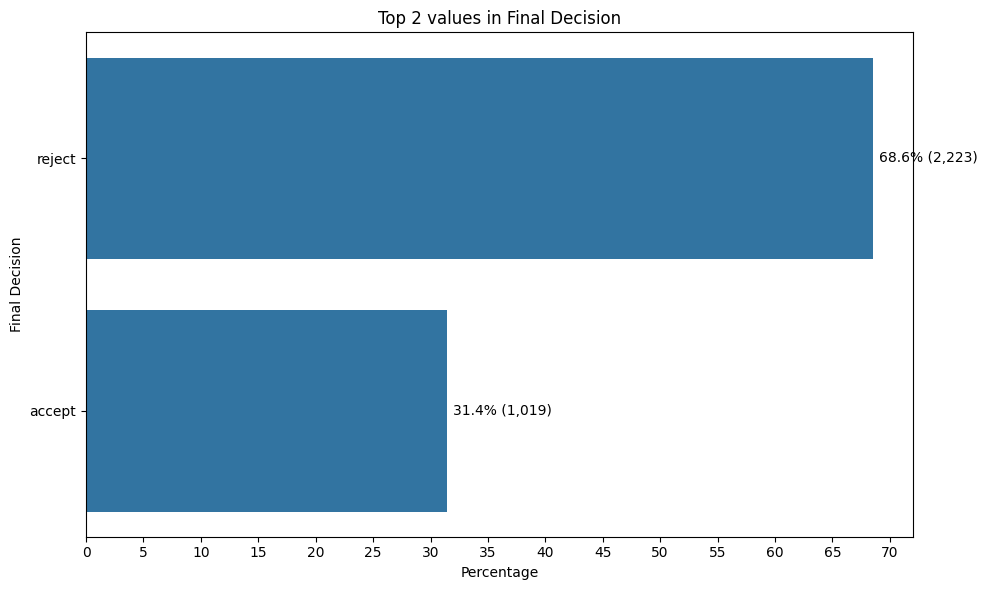

Statistics for Final Decision:
Total unique values: 2
Top 2 values:
Final Decision
reject    68.568785
accept    31.431215
Name: count, dtype: float64


In [ ]:
plot_column_distribution(PeerConf, 'Final Decision', top_k=2)

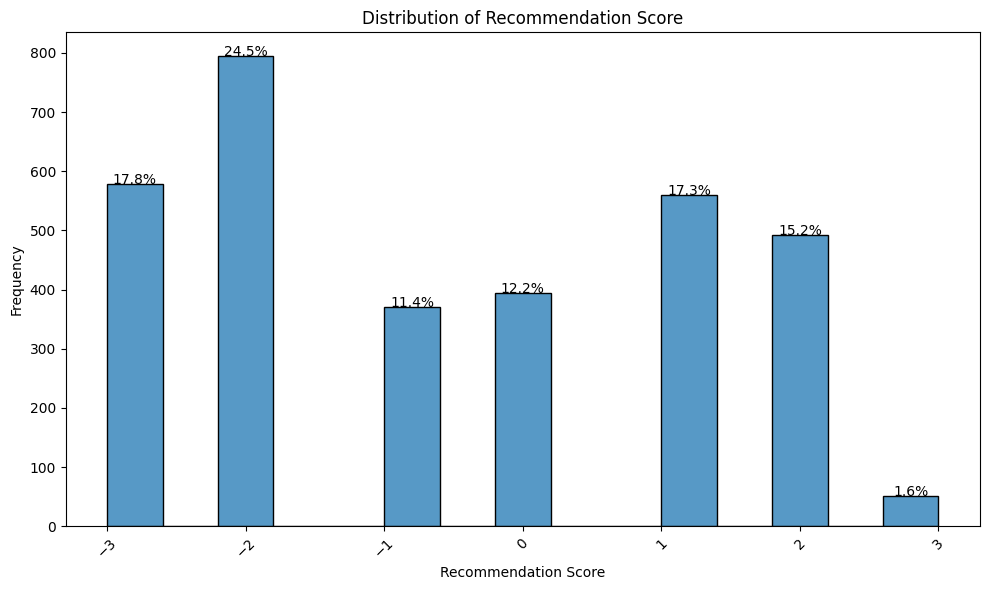

Statistics for Recommendation Score:
count    3242.000000
mean       -0.615361
std         1.801244
min        -3.000000
25%        -2.000000
50%        -1.000000
75%         1.000000
max         3.000000
Name: Recommendation Score, dtype: float64


In [ ]:
plot_column_distribution(PeerConf, 'Recommendation Score', top_k=20)

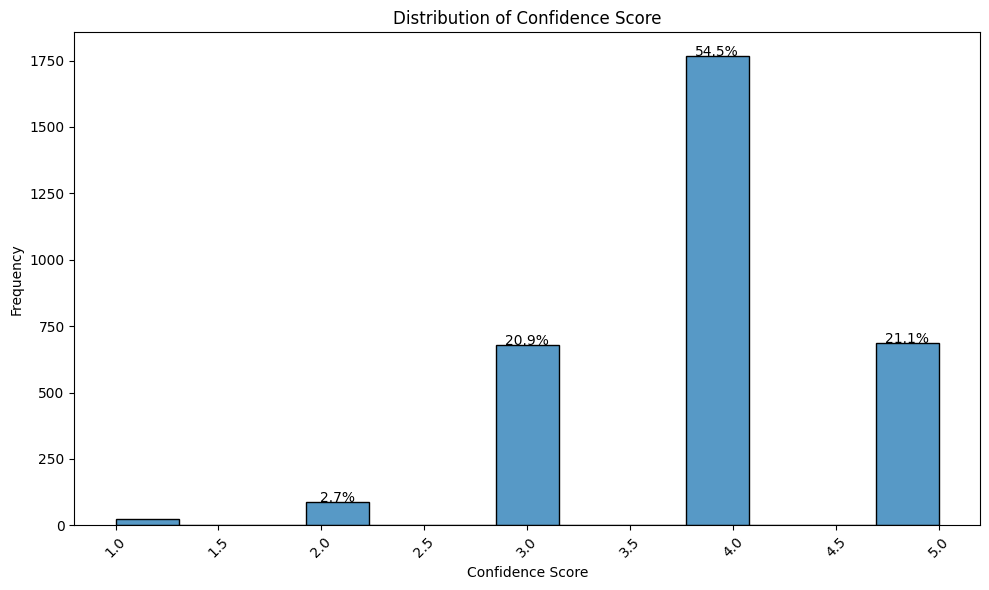

Statistics for Confidence Score:
count    3242.000000
mean        3.926897
std         0.765597
min         1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Confidence Score, dtype: float64


In [ ]:
plot_column_distribution(PeerConf, 'Confidence Score', top_k=20)

## Publons

In [ ]:
publons = publons.dropna()
publons

,Unnamed: 0,review_hash,journal_impact_factor,reviewer_country,review_length_words,top_field
0,0,ee3048d075a7aff5d2cd6283efdd99b8f25da55e,2.265,Mexico,1282,Medical Specialties and Medical Technologies
1,1,95d474b96aac9183872f7ba8fb43540baad3ef10,4.396,USA,443,Medical Specialties and Medical Technologies
2,3,9b8db39d50c44c4ed8dfebecf9789c8a1aec1aa3,4.396,USA,983,Medical Specialties and Medical Technologies
7,9,5c17ccc82ea4e3b7af586e059a6bc41d3670b370,1.683,Bangladesh,135,Applied Physical Sciences & Engineering
11,13,7a25368a41c358896b3ef0b4fbef51d27e8312cd,0.853,Australia,316,Biology and Applied Biological Sciences
...,...,...,...,...,...,...
498166,618060,3526af02ca8a9b7111f835889b1ffa0852b7d8f2,0.829,China,279,Computer Science & Engineering
498167,618061,b1315fb09640b31ebe3fa2abfb7554b371793e9a,2.617,USA,933,Medical Specialties and Medical Technologies
498168,618062,2627ec4f2c2b29ca0c2739116fd50b0404bc68c2,2.635,Iran,102,Applied Physical Sciences & Engineering
498169,618065,0248e823c1962b8ba8dd40e13f3bdf9f3123c4ad,1.263,Egypt,143,Applied Physical Sciences & Engineering


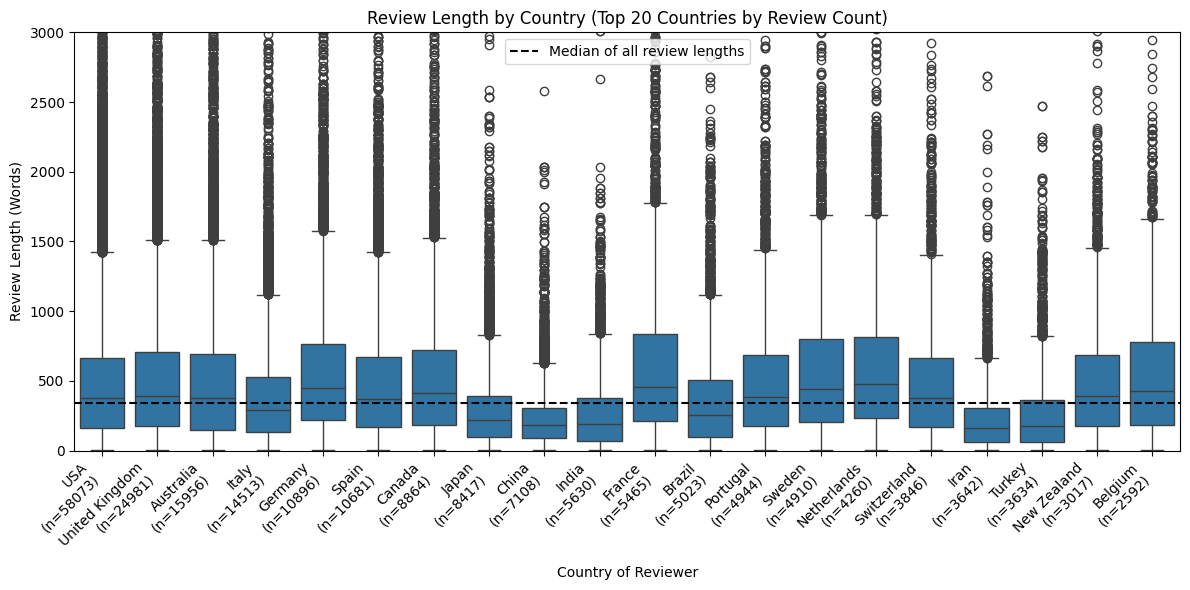

In [ ]:
df = publons
# 2. Identify top 20 countries by review count
country_counts = df['reviewer_country'].value_counts()
top_20_countries = country_counts.head(20).index

# 3. Filter the DataFrame to only include top 20 countries
df_top20 = df[df['reviewer_country'].isin(top_20_countries)]

# 4. Calculate overall median of review length (for the dashed horizontal line)
overall_median = df_top20['review_length_words'].median()

# 5. Sort the countries by descending count so the x-axis matches "top" order
country_order = df_top20['reviewer_country'].value_counts().index

# 6. Create the boxplot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.boxplot(
    x='reviewer_country',
    y='review_length_words',
    data=df_top20,
    order=country_order,
    showfliers=True  # Set to False if you want to hide individual outliers
)

# 7. Add a horizontal line for the overall median
plt.axhline(overall_median, color='black', linestyle='--', label='Median of all review lengths')

# 8. Annotate x-axis labels with "n=..."
#    This shows how many reviews each country has in your top-20 subset.
country_n = df_top20['reviewer_country'].value_counts()
plt.xticks(
    ticks=range(len(country_order)),
    labels=[f"{c}\n(n={country_n[c]})" for c in country_order],
    rotation=45,   # or 90, depending on your preference
    ha='right'
)

# 9. Set labels and limits
plt.xlabel("Country of Reviewer")
plt.ylabel("Review Length (Words)")
plt.ylim(0, 3000)  # Match the range in your example if desired
plt.title("Review Length by Country (Top 20 Countries by Review Count)")

# 10. Add legend and tighten layout
plt.legend()
plt.tight_layout()

# 11. Display the plot
plt.show()

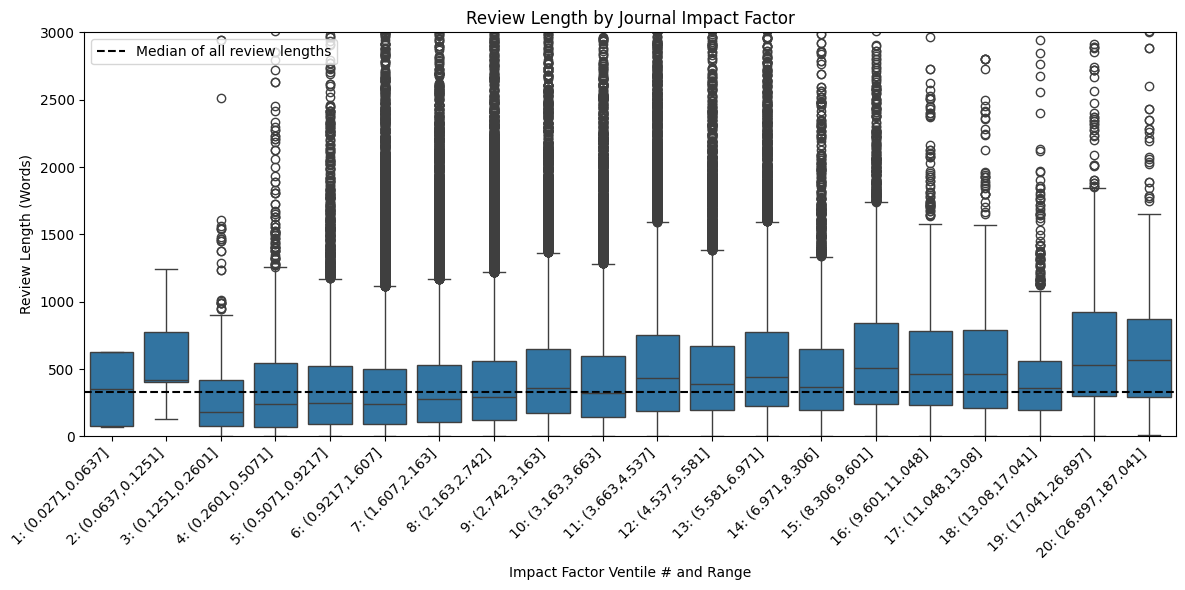

In [ ]:

# -- A) Using automatic ventiles via qcut --
# This divides your data into 20 equal-sized groups (by count).
# df['IF_ventile'] = pd.qcut(df['impact_factor'], q=20, precision=4)

# OR

# -- B) Using custom bins to match exact intervals from your figure --
# Make sure these bin edges cover the full range of your impact factors.
# Example bin edges (21 edges for 20 intervals):
bin_edges = [
    0.0271, 0.0637, 0.1251, 0.2601, 0.5071,
    0.9217, 1.607, 2.163, 2.742, 3.163,
    3.663, 4.537, 5.581, 6.971, 8.306,
    9.601, 11.048, 13.08, 17.041, 26.897,
    187.041
]
# Create labels that match the intervals in your figure
labels = []
for i in range(1, len(bin_edges)):
    left = bin_edges[i-1]
    right = bin_edges[i]
    labels.append(f"{i}: ({left},{right}]")

df['IF_ventile'] = pd.cut(
    df['journal_impact_factor'],
    bins=bin_edges,
    labels=labels,
    right=True,     # right-closed intervals: (left, right]
    include_lowest=True
)

# 2. Calculate overall median of review length (for the dashed line)
overall_median = df['review_length_words'].median()

# 3. Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='IF_ventile',
    y='review_length_words',
    data=df,
    order=labels,       # ensure the ventiles appear in ascending order
    showfliers=True     # set to False if you want to hide outliers
)

# 4. Add a horizontal line for the overall median
plt.axhline(overall_median, color='black', linestyle='--', label='Median of all review lengths')

# 5. Customize plot aesthetics
plt.xlabel("Impact Factor Ventile # and Range")
plt.ylabel("Review Length (Words)")
plt.title("Review Length by Journal Impact Factor")

# Optionally set y-axis limits to match your figure
plt.ylim(0, 3000)

plt.legend()
plt.xticks(rotation=45, ha='right')  # rotate labels for readability
plt.tight_layout()
plt.show()


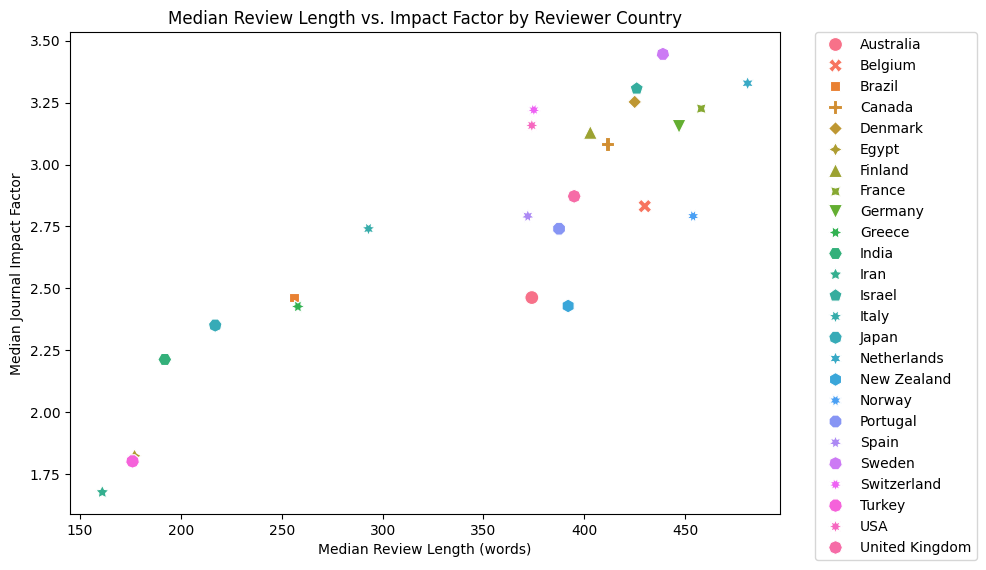

In [ ]:


# 1. Read your CSV file into a DataFrame
df = publons

# 2. Define the countries of interest
countries_of_interest = [
    'Australia', 'Belgium', 'Brazil', 'Canada', 'Denmark',
    'Egypt', 'Finland', 'France', 'Germany', 'Greece',
    'India', 'Iran', 'Israel', 'Italy', 'Japan', 'Netherlands',
    'New Zealand', 'Norway', 'Portugal', 'Spain', 'Sweden',
    'Switzerland', 'Turkey', 'USA', 'United Kingdom'
]

# 3. Filter the DataFrame to only those countries
df_filtered = df[df['reviewer_country'].isin(countries_of_interest)]

# 4. Group by country to compute median values
grouped = df_filtered.groupby('reviewer_country', as_index=False).agg({
    'review_length_words': 'median',
    'journal_impact_factor': 'median'
})

# Optionally rename columns for clarity
grouped = grouped.rename(columns={
    'review_length_words': 'median_review_length',
    'journal_impact_factor': 'median_if'
})

# 5. Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped,
    x='median_review_length',
    y='median_if',
    hue='reviewer_country',   # different colors
    style='reviewer_country', # different marker shapes
    s=100                     # marker size
)

# 6. Label axes and add a title
plt.xlabel("Median Review Length (words)")
plt.ylabel("Median Journal Impact Factor")
plt.title("Median Review Length vs. Impact Factor by Reviewer Country")

# 7. Position the legend so it doesn't obscure the data
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# 8. Final formatting
plt.tight_layout()
plt.show()


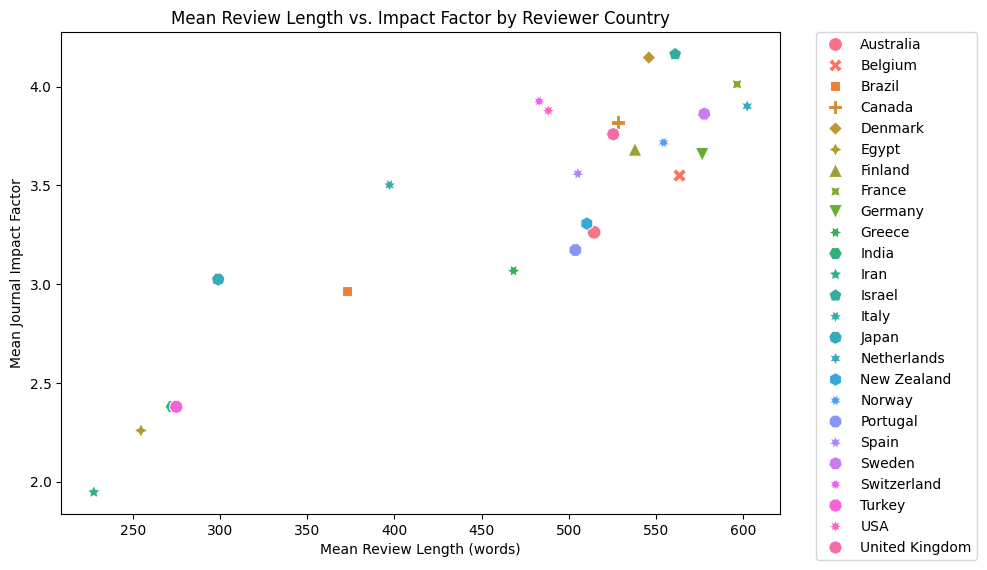

In [ ]:


# 1. Use your DataFrame (assuming 'publons' is already defined)
df = publons

# 2. Define the countries of interest
countries_of_interest = [
    'Australia', 'Belgium', 'Brazil', 'Canada', 'Denmark',
    'Egypt', 'Finland', 'France', 'Germany', 'Greece',
    'India', 'Iran', 'Israel', 'Italy', 'Japan', 'Netherlands',
    'New Zealand', 'Norway', 'Portugal', 'Spain', 'Sweden',
    'Switzerland', 'Turkey', 'USA', 'United Kingdom'
]

# 3. Filter the DataFrame to only those countries
df_filtered = df[df['reviewer_country'].isin(countries_of_interest)]

# 4. Group by country to compute mean values
grouped = df_filtered.groupby('reviewer_country', as_index=False).agg({
    'review_length_words': 'mean',
    'journal_impact_factor': 'mean'
})

# Rename columns for clarity
grouped = grouped.rename(columns={
    'review_length_words': 'mean_review_length',
    'journal_impact_factor': 'mean_if'
})

# 5. Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=grouped,
    x='mean_review_length',
    y='mean_if',
    hue='reviewer_country',   # different colors per country
    style='reviewer_country', # different marker shapes per country
    s=100                     # marker size
)

# 6. Label axes and add a title
plt.xlabel("Mean Review Length (words)")
plt.ylabel("Mean Journal Impact Factor")
plt.title("Mean Review Length vs. Impact Factor by Reviewer Country")

# 7. Position the legend so it doesn't obscure the data
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# 8. Final formatting
plt.tight_layout()
plt.show()


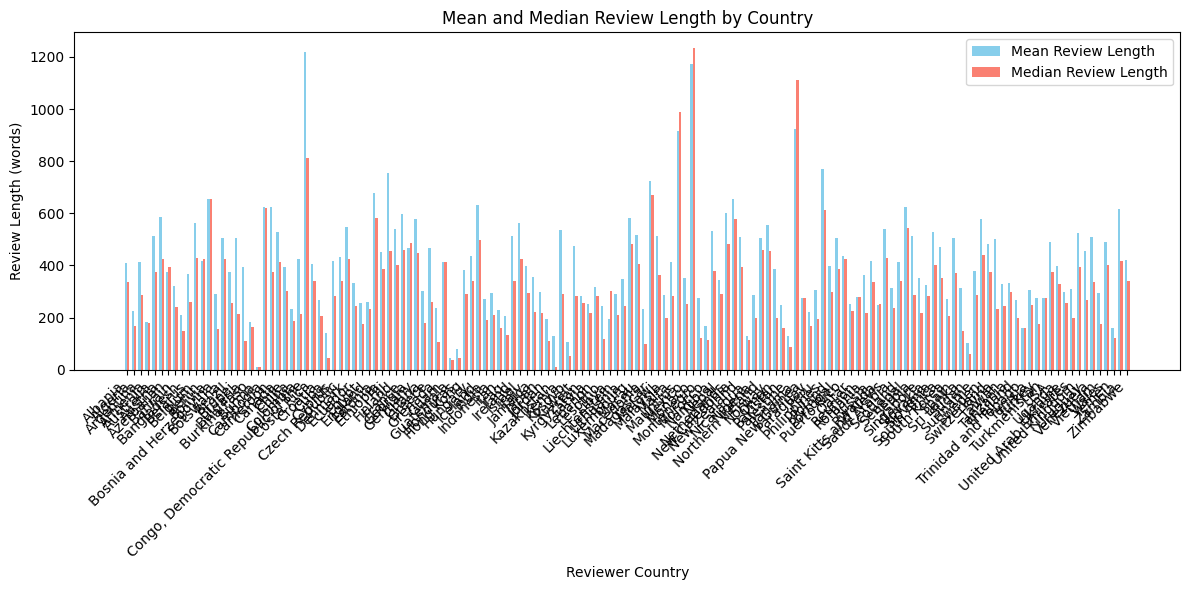

In [ ]:

# 2. Group by reviewer_country and compute mean and median review length
country_stats = df.groupby("reviewer_country")["review_length_words"].agg(['mean', 'median']).reset_index()

# Optional: sort countries alphabetically (or you can sort by any other criteria)
country_stats = country_stats.sort_values("reviewer_country")

# 3. Set up the positions and width for the grouped bars
n_countries = len(country_stats)
indices = np.arange(n_countries)  # x locations for the groups
bar_width = 0.35  # width of the bars

# 4. Create the plot
plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width/2, country_stats['mean'], bar_width, label='Mean Review Length', color='skyblue')
plt.bar(indices + bar_width/2, country_stats['median'], bar_width, label='Median Review Length', color='salmon')

# 5. Add labels, title, and legend
plt.xlabel("Reviewer Country")
plt.ylabel("Review Length (words)")
plt.title("Mean and Median Review Length by Country")
plt.xticks(indices, country_stats['reviewer_country'], rotation=45, ha='right')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
country_stats

,reviewer_country,mean,median
0,Albania,409.368421,337.0
1,Algeria,223.260204,167.5
2,Argentina,411.158485,286.0
3,Armenia,181.857143,180.0
4,Australia,514.520745,374.0
...,...,...,...
141,Vietnam,292.890411,175.0
142,Wales,488.533742,402.0
143,Yemen,160.215686,121.0
144,Zambia,614.750000,418.5


In [ ]:

# 1. Read the CSV file into a DataFrame
df = publons

# 2. Group by reviewer_country for the review length statistics
grouped = df.groupby("reviewer_country")["review_length_words"]

# 3. Compute the basic statistics
stats_df = grouped.agg(['count', 'mean', 'median', 'std', 'min', 'max']).reset_index()

# 4. Compute additional percentiles and derived statistics
stats_df['25%'] = grouped.quantile(0.25).values
stats_df['75%'] = grouped.quantile(0.75).values
stats_df['IQR'] = stats_df['75%'] - stats_df['25%']
stats_df['skew'] = grouped.skew().values
stats_df['kurtosis'] = grouped.apply(lambda x: x.kurtosis()).values


# 5. Display the new DataFrame with the statistics
stats_df

,reviewer_country,count,mean,median,std,min,max,25%,75%,IQR,skew,kurtosis
0,Albania,19,409.368421,337.0,309.927986,10,1354,221.50,548.50,327.00,1.472808,3.791246
1,Algeria,196,223.260204,167.5,252.216612,2,1799,58.75,307.25,248.50,2.912248,12.181007
2,Argentina,713,411.158485,286.0,443.447572,4,2691,104.00,522.00,418.00,2.042460,4.952264
3,Armenia,7,181.857143,180.0,143.627329,19,452,84.00,227.00,143.00,1.082220,1.448262
4,Australia,15956,514.520745,374.0,545.808890,1,10661,150.00,695.00,545.00,2.891052,17.853951
...,...,...,...,...,...,...,...,...,...,...,...,...
141,Vietnam,73,292.890411,175.0,271.228919,12,979,92.00,428.00,336.00,0.958145,-0.163856
142,Wales,163,488.533742,402.0,424.184916,1,2347,157.00,737.00,580.00,1.345316,2.378098
143,Yemen,51,160.215686,121.0,155.957470,1,518,27.00,265.50,238.50,0.873784,-0.312630
144,Zambia,8,614.750000,418.5,684.549852,98,2194,239.25,637.50,398.25,2.143667,5.065217


In [ ]:
stats_df = stats_df.dropna()
stats_df = stats_df.sort_values(by='count', ascending=False)
stats_df

,reviewer_country,count,mean,median,std,min,max,25%,75%,IQR,skew,kurtosis
134,USA,58073,488.292735,374.0,476.756103,1,7889,164.00,667.00,503.00,2.539744,13.165452
138,United Kingdom,24981,525.522077,395.0,528.768080,1,8725,175.00,708.00,533.00,2.870775,16.749140
4,Australia,15956,514.520745,374.0,545.808890,1,10661,150.00,695.00,545.00,2.891052,17.853951
58,Italy,14513,397.198649,293.0,426.016721,1,9764,133.00,528.00,395.00,4.921269,65.475115
42,Germany,10896,576.555525,447.0,550.038885,1,8344,222.00,764.00,542.00,2.853518,17.117598
...,...,...,...,...,...,...,...,...,...,...,...,...
133,Turkmenistan,4,273.750000,275.0,138.181945,139,406,163.00,385.75,222.75,-0.013277,-5.547935
69,Lesotho,4,244.750000,117.5,333.483008,13,731,35.50,326.75,291.25,1.692653,2.792883
11,Benin,4,415.000000,426.0,35.042831,364,444,410.50,430.50,20.00,-1.635969,3.082324
90,Nicaragua,4,127.250000,113.5,29.261750,111,171,111.00,129.75,18.75,1.961905,3.863605


In [ ]:

import plotly.express as px

# 1. Load the aggregated dataset
# Replace 'aggregated_data.csv' with the actual file name containing your dataset.
# stats_df = pd.read_csv("aggregated_data.csv")

# 2. Create the choropleth map using the 'mean' column for the color scale
fig = px.choropleth(
    stats_df,
    locations="reviewer_country",         # Country names column
    locationmode="country names",           # Interpret the names as standard country names
    color="mean",                           # Color each country by the 'mean' column value
    hover_name="reviewer_country",          # Display the country name on hover
    color_continuous_scale=px.colors.sequential.Plasma,
    title="Mean Review Length by Country"
)

# 3. Display the interactive globe map
fig.show()

# Preprocessing

## Publons

In [ ]:
publons

,Unnamed: 0,review_hash,journal_impact_factor,reviewer_country,review_length_words,top_field,IF_ventile
0,0,ee3048d075a7aff5d2cd6283efdd99b8f25da55e,2.265,Mexico,1282,Medical Specialties and Medical Technologies,"8: (2.163,2.742]"
1,1,95d474b96aac9183872f7ba8fb43540baad3ef10,4.396,USA,443,Medical Specialties and Medical Technologies,"11: (3.663,4.537]"
2,3,9b8db39d50c44c4ed8dfebecf9789c8a1aec1aa3,4.396,USA,983,Medical Specialties and Medical Technologies,"11: (3.663,4.537]"
7,9,5c17ccc82ea4e3b7af586e059a6bc41d3670b370,1.683,Bangladesh,135,Applied Physical Sciences & Engineering,"7: (1.607,2.163]"
11,13,7a25368a41c358896b3ef0b4fbef51d27e8312cd,0.853,Australia,316,Biology and Applied Biological Sciences,"5: (0.5071,0.9217]"
...,...,...,...,...,...,...,...
498166,618060,3526af02ca8a9b7111f835889b1ffa0852b7d8f2,0.829,China,279,Computer Science & Engineering,"5: (0.5071,0.9217]"
498167,618061,b1315fb09640b31ebe3fa2abfb7554b371793e9a,2.617,USA,933,Medical Specialties and Medical Technologies,"8: (2.163,2.742]"
498168,618062,2627ec4f2c2b29ca0c2739116fd50b0404bc68c2,2.635,Iran,102,Applied Physical Sciences & Engineering,"8: (2.163,2.742]"
498169,618065,0248e823c1962b8ba8dd40e13f3bdf9f3123c4ad,1.263,Egypt,143,Applied Physical Sciences & Engineering,"6: (0.9217,1.607]"


In [ ]:
stats_df

,reviewer_country,count,mean,median,std,min,max,25%,75%,IQR,skew,kurtosis
134,USA,58073,488.292735,374.0,476.756103,1,7889,164.00,667.00,503.00,2.539744,13.165452
138,United Kingdom,24981,525.522077,395.0,528.768080,1,8725,175.00,708.00,533.00,2.870775,16.749140
4,Australia,15956,514.520745,374.0,545.808890,1,10661,150.00,695.00,545.00,2.891052,17.853951
58,Italy,14513,397.198649,293.0,426.016721,1,9764,133.00,528.00,395.00,4.921269,65.475115
42,Germany,10896,576.555525,447.0,550.038885,1,8344,222.00,764.00,542.00,2.853518,17.117598
...,...,...,...,...,...,...,...,...,...,...,...,...
133,Turkmenistan,4,273.750000,275.0,138.181945,139,406,163.00,385.75,222.75,-0.013277,-5.547935
69,Lesotho,4,244.750000,117.5,333.483008,13,731,35.50,326.75,291.25,1.692653,2.792883
11,Benin,4,415.000000,426.0,35.042831,364,444,410.50,430.50,20.00,-1.635969,3.082324
90,Nicaragua,4,127.250000,113.5,29.261750,111,171,111.00,129.75,18.75,1.961905,3.863605


In [ ]:
stats_df.reset_index(drop=True, inplace=True)

In [ ]:
stats_df

,reviewer_country,count,mean,median,std,min,max,25%,75%,IQR,skew,kurtosis
0,USA,58073,488.292735,374.0,476.756103,1,7889,164.00,667.00,503.00,2.539744,13.165452
1,United Kingdom,24981,525.522077,395.0,528.768080,1,8725,175.00,708.00,533.00,2.870775,16.749140
2,Australia,15956,514.520745,374.0,545.808890,1,10661,150.00,695.00,545.00,2.891052,17.853951
3,Italy,14513,397.198649,293.0,426.016721,1,9764,133.00,528.00,395.00,4.921269,65.475115
4,Germany,10896,576.555525,447.0,550.038885,1,8344,222.00,764.00,542.00,2.853518,17.117598
...,...,...,...,...,...,...,...,...,...,...,...,...
134,Turkmenistan,4,273.750000,275.0,138.181945,139,406,163.00,385.75,222.75,-0.013277,-5.547935
135,Lesotho,4,244.750000,117.5,333.483008,13,731,35.50,326.75,291.25,1.692653,2.792883
136,Benin,4,415.000000,426.0,35.042831,364,444,410.50,430.50,20.00,-1.635969,3.082324
137,Nicaragua,4,127.250000,113.5,29.261750,111,171,111.00,129.75,18.75,1.961905,3.863605


In [ ]:
# Group by country and create lists of review lengths
country_reviews = publons.groupby('reviewer_country')['review_length_words'].apply(list).to_dict()

# Remove any country keys that are NaN
if pd.NA in country_reviews or np.nan in country_reviews:
    country_reviews = {k: v for k, v in country_reviews.items() if not pd.isna(k)}

In [ ]:
# create a histogram of review lengths for each country
country_reviews

{'Albania': [96,
  237,
  214,
  214,
  229,
  229,
  337,
  337,
  518,
  518,
  476,
  476,
  11,
  579,
  579,
  1354,
  10,
  682,
  682],
 'Algeria': [64,
  64,
  268,
  268,
  1244,
  1381,
  1381,
  69,
  9,
  2,
  68,
  549,
  549,
  47,
  150,
  70,
  12,
  9,
  65,
  464,
  464,
  37,
  71,
  290,
  31,
  80,
  20,
  110,
  413,
  221,
  332,
  332,
  151,
  151,
  192,
  192,
  460,
  460,
  125,
  125,
  158,
  297,
  297,
  168,
  168,
  131,
  4,
  4,
  147,
  147,
  45,
  83,
  83,
  121,
  121,
  41,
  51,
  286,
  166,
  167,
  167,
  24,
  31,
  373,
  373,
  628,
  628,
  70,
  14,
  68,
  205,
  205,
  20,
  532,
  532,
  47,
  422,
  422,
  60,
  60,
  220,
  220,
  187,
  187,
  93,
  93,
  249,
  249,
  32,
  234,
  234,
  92,
  53,
  31,
  2,
  2,
  979,
  42,
  40,
  174,
  176,
  256,
  76,
  226,
  40,
  82,
  72,
  82,
  34,
  160,
  474,
  355,
  253,
  85,
  25,
  9,
  9,
  95,
  19,
  28,
  28,
  185,
  186,
  709,
  709,
  320,
  32,
  420,
  193,
  193,

In [ ]:
country_IF = publons.groupby('reviewer_country')['journal_impact_factor'].mean()
country_IF = (country_IF - country_IF.min()) / (country_IF.max() - country_IF.min())
country_IF

,journal_impact_factor
reviewer_country,
Albania,0.063306
Algeria,0.177524
Argentina,0.432028
Armenia,0.214283
Australia,0.430149
...,...
Vietnam,0.255819
Wales,0.495255
Yemen,0.237536


## ReviewData

In [ ]:
reviews_df

,rid,review_of,title,review,rating,confidence,raw_rating,raw_confidence
0,112,BJlk4QeajE,"sensible approach to RL for compilers, might b...",The authors describe an RL approach to speed u...,0.555556,0.25,4: Weak Accept,2: The reviewer is willing to defend the evalu...
1,113,BJlk4QeajE,Accept. Well written and evaluated. But not a ...,This paper proposes a reinforcement learning a...,0.555556,0.75,4: Weak Accept,4: The reviewer is confident but not absolutel...
2,114,H1xSXdV0i4,An extension of HER to incorporate visual task...,"In this work, the authors proposed HALGAN, a t...",0.500000,0.75,3: Borderline,4: The reviewer is confident but not absolutel...
3,115,H1xSXdV0i4,GANs to add targets to failed trajectories for...,This paper presents an approach to applying HE...,0.555556,0.75,4: Weak Accept,4: The reviewer is confident but not absolutel...
4,116,B1l3hfy6jN,An interesting application of reinforcement le...,"The paper applies reinforcement learning, in p...",0.250000,0.75,2: Weak Reject,4: The reviewer is confident but not absolutel...
...,...,...,...,...,...,...,...,...
4543,6871,rJPcZ3txx,review,The paper details an implementation of sparse-...,0.666667,0.50,"7: Good paper, accept",3: The reviewer is fairly confident that the e...
4544,6872,rJPcZ3txx,Impressive empirical results; minimal research...,The authors provide a well engineered solution...,0.555556,0.50,6: Marginally above acceptance threshold,3: The reviewer is fairly confident that the e...
4545,6873,rJo9n9Feg,Unclear,Game of tic-tac-toe is considered. 1029 tic-ta...,0.222222,1.00,3: Clear rejection,5: The reviewer is absolutely certain that the...
4546,6874,rJo9n9Feg,"Novel experiments, but the results and signifi...",Summary\n===\nThis paper presents tic-tac-toe ...,0.222222,0.50,3: Clear rejection,3: The reviewer is fairly confident that the e...


In [ ]:
reviews_df['confidence'].unique()

array([0.25, 0.75, 0.  , 1.  , 0.5 ])

In [ ]:
papers_df

,pid,title,abstract,decision,submitted_to
0,BJlk4QeajE,Reinforcement Learning and Adaptive Sampling f...,Achieving faster execution with shorter compil...,1,1
1,H1xSXdV0i4,Addressing Sample Complexity in Visual Tasks U...,Reinforcement Learning (RL) algorithms typical...,1,1
2,B1l3hfy6jN,Learning State Switching for Improved Explorat...,Reinforcement learning has been used to achiev...,0,1
3,HyeNo333jE,A Spectral Method for Off-Policy Evaluation in...,Contextual bandits capture the partial-feedbac...,0,1
4,SJlCkwN8iV,Real-world Video Adaptation with Reinforcement...,Client-side video players employ adaptive bitr...,1,1
...,...,...,...,...,...
1622,SJDaqqveg,An Actor-Critic Algorithm for Sequence Prediction,We present an approach to training neural netw...,1,10
1623,HJhcg6Fxg,Binary Paragraph Vectors,Recently Le & Mikolov described two log-linear...,0,10
1624,BJ3filKll,Efficient Representation of Low-Dimensional Ma...,We consider the ability of deep neural network...,1,10
1625,rJPcZ3txx,Faster CNNs with Direct Sparse Convolutions an...,Phenomenally successful in practical inference...,1,10


In [ ]:
cont_df

,ctr_aid,ctr_pid
0,5498,BJlk4QeajE
1,681,BJlk4QeajE
2,4090,BJlk4QeajE
3,3087,H1xSXdV0i4
4,5852,H1xSXdV0i4
...,...,...
6254,2219,rJo9n9Feg
6255,4564,rJo9n9Feg
6256,2674,rJo9n9Feg
6257,3148,rJo9n9Feg


In [ ]:
authors_df

,aid,name,email,inst_guess,world_rank,document_count,citation_count,h_index,coauthor_count,years_experience
0,0,Hsun-An Chiang,laba15454@gmail.com,,-,NaN,NaN,NaN,NaN,NaN
1,1,Stephen Phillips,stephi@seas.upenn.edu,University of Pennsylvania,61,31.0,811.0,14.0,55.0,34.0
2,2,Sham Kakade,sham@cs.washington.edu,"University of Washington, Seattle",54,115.0,5373.0,37.0,102.0,19.0
3,3,Douglas Eck,deck@google.com,Google LLC,101-150,64.0,1307.0,19.0,90.0,18.0
4,4,Tomas Kocisky,tkocisky@google.com,Google LLC,10,4.0,485.0,3.0,12.0,4.0
...,...,...,...,...,...,...,...,...,...,...
6553,6553,Junyoung Chung,junyoung.chung@umontreal.ca,University of Montreal,101-150,6.0,347.0,4.0,14.0,4.0
6554,6554,Xavier Roca,xavier.roca@uab.cat,,99,75.0,697.0,13.0,69.0,20.0
6555,6555,Zhengping Che,zche@usc.edu,University of Southern California,49,12.0,248.0,7.0,31.0,3.0
6556,6556,Daniel Alte,daniel.alte@gris.tu-darmstadt.de,Technische Universität Darmstadt,-,NaN,NaN,NaN,NaN,NaN


In [ ]:
# One-step join of all three dataframes
RD_df = (
    authors_df
    .merge(cont_df, left_on='aid', right_on='ctr_aid', how='inner')
    .merge(papers_df, left_on='ctr_pid', right_on='pid', how='inner')
)
RD_df

,aid,name,email,inst_guess,world_rank,document_count,citation_count,h_index,coauthor_count,years_experience,ctr_aid,ctr_pid,pid,title,abstract,decision,submitted_to
0,1,Stephen Phillips,stephi@seas.upenn.edu,University of Pennsylvania,61,31.0,811.0,14.0,55.0,34.0,1,SJLlmG-AZ,SJLlmG-AZ,Understanding image motion with group represen...,Motion is an important signal for agents in dy...,1,8
1,2,Sham Kakade,sham@cs.washington.edu,"University of Washington, Seattle",54,115.0,5373.0,37.0,102.0,19.0,2,HkxzljA4_N,HkxzljA4_N,Online Meta-Learning,A central capability of intelligent systems is...,1,2
2,3,Douglas Eck,deck@google.com,Google LLC,101-150,64.0,1307.0,19.0,90.0,18.0,3,Sksy1ckvG,Sksy1ckvG,Towards Mixed-initiative generation of multi-c...,We argue for the benefit of designing deep gen...,1,7
3,3,Douglas Eck,deck@google.com,Google LLC,101-150,64.0,1307.0,19.0,90.0,18.0,3,HJr4QJ26W,HJr4QJ26W,Improving image generative models with human i...,GANs provide a framework for training generati...,0,8
4,3,Douglas Eck,deck@google.com,Google LLC,101-150,64.0,1307.0,19.0,90.0,18.0,3,Hy6GHpkCW,Hy6GHpkCW,A Neural Representation of Sketch Drawings,"We present sketch-rnn, a recurrent neural netw...",1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6254,6551,Matthias Lutz,matthias.lutz@uksh.de,,15,106.0,3665.0,28.0,64.0,29.0,6551,SJWY1Ujsz,SJWY1Ujsz,Adversarial Training for Patient-Independent F...,Deep learning methods have shown impressive re...,1,6
6255,6552,Babak Ehteshami Bejnordi,babakint@gmail.com,,101-150,11.0,1359.0,6.0,120.0,4.0,6552,rycG7Zhof,rycG7Zhof,Soft tissue lesion detection in mammography us...,Computer-aided detection or decision support s...,0,5
6256,6553,Junyoung Chung,junyoung.chung@umontreal.ca,University of Montreal,101-150,6.0,347.0,4.0,14.0,4.0,6553,S1di0sfgl,S1di0sfgl,Hierarchical Multiscale Recurrent Neural Networks,Learning both hierarchical and temporal repres...,1,10
6257,6555,Zhengping Che,zche@usc.edu,University of Southern California,49,12.0,248.0,7.0,31.0,3.0,6555,ByJbJwxCW,ByJbJwxCW,Relational Multi-Instance Learning for Concept...,Recent advances in computing technology and se...,0,8


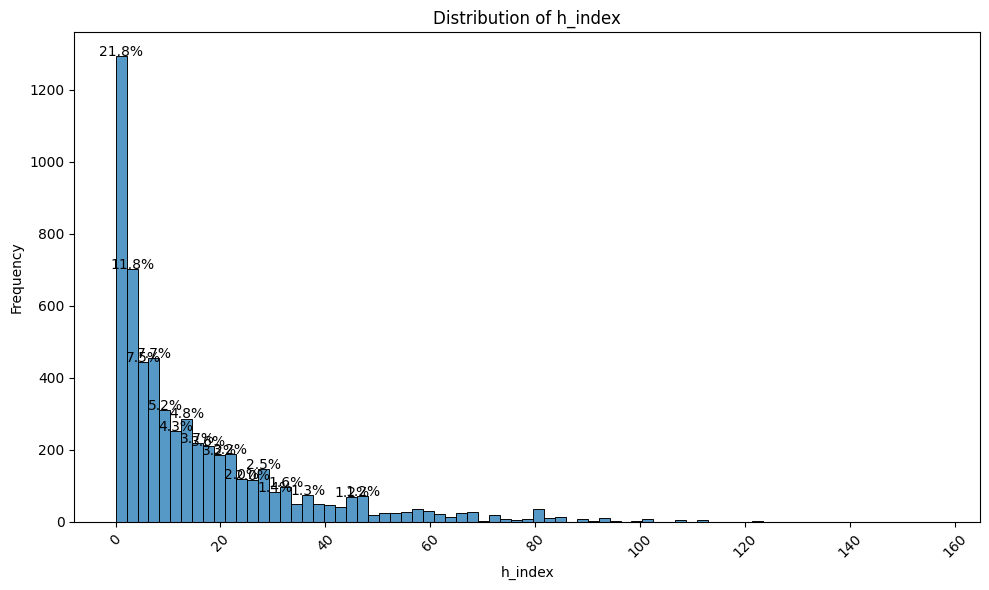

Statistics for h_index:
count    5929.000000
mean       16.051273
std        18.917154
min         0.000000
25%         3.000000
50%         9.000000
75%        22.000000
max       157.000000
Name: h_index, dtype: float64


In [ ]:
plot_column_distribution(RD_df, 'h_index', top_k=50, figsize=(10, 6), kde=False)

In [ ]:
RD_df['h_index'].quantile(0.9)

41.19999999999982

## PeerRead + PeerConf

In [ ]:
def create_reviews_dataframe(directory_path):
    """
    Create a DataFrame with reviews from JSON files in the specified directory and its subdirectories.

    Args:
        directory_path: Path to the directory containing JSON files

    Returns:
        pandas DataFrame with columns: id, title, reviews, confidence
    """
    # Initialize an empty list to store rows
    data_rows = []

    # Walk through the directory and its subdirectories
    for root, dirs, files in os.walk(directory_path):
        for filename in files:
            if filename.lower().endswith('.json'):
                file_path = os.path.join(root, filename)

                try:
                    # Read the JSON file
                    with open(file_path, 'r', encoding='utf-8') as file:
                        data = json.load(file)

                    # Check if 'reviews' key exists and is not empty
                    if 'reviews' in data and data['reviews']:
                        paper_id = data.get('id', '')
                        paper_title = data.get('title', '')

                        # Process each review
                        for review in data['reviews']:
                            comments = review.get('comments', '')
                            confidence = review.get('REVIEWER_CONFIDENCE', '')

                            # Add row to data
                            data_rows.append({
                                'id': paper_id,
                                'title': paper_title,
                                'reviews': comments,
                                'confidence': confidence
                            })
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")

    # Create DataFrame from collected rows
    df = pd.DataFrame(data_rows)

    # Print summary
    print(f"Created DataFrame with {len(df)} reviews from directory: {directory_path}")
    print(f"Number of unique papers: {df['id'].nunique()}")

    return df

# Example usage
directory_path = "/content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17"
PR_df = create_reviews_dataframe(directory_path)

# Display the first few rows
print("\nSample of the DataFrame:")
print(PR_df.head())

Created DataFrame with 275 reviews from directory: /content/drive/MyDrive/BD PROJECT/DATA/PeerRead/ACL17
Number of unique papers: 137

Sample of the DataFrame:
    id                                              title  \
0  173  Determining Gains Acquired from Word Embedding...   
1  173  Determining Gains Acquired from Word Embedding...   
2  352  Adversarial Multi-task Learning for Text Class...   
3  352  Adversarial Multi-task Learning for Text Class...   
4   37  Sequential Matching Network: A New Architectur...   

                                             reviews confidence  
0  - Strengths:\n\n- Weaknesses:\nMany grammar er...          4  
1  - Strengths: Introduces  a new document cluste...          4  
2  This paper introduces new configurations and t...          2  
3  # Paper summary\n\nThis paper presents a metho...          3  
4  - Strengths:\n\nRelatively clear description o...          2  


In [ ]:
PR_df

,id,title,reviews,confidence
0,173,Determining Gains Acquired from Word Embedding...,- Strengths:\n\n- Weaknesses:\nMany grammar er...,4
1,173,Determining Gains Acquired from Word Embedding...,- Strengths: Introduces a new document cluste...,4
2,352,Adversarial Multi-task Learning for Text Class...,This paper introduces new configurations and t...,2
3,352,Adversarial Multi-task Learning for Text Class...,# Paper summary\n\nThis paper presents a metho...,3
4,37,Sequential Matching Network: A New Architectur...,- Strengths:\n\nRelatively clear description o...,2
...,...,...,...,...
270,96,Sarcasm SIGN: Interpreting Sarcasm with Sentim...,- Strengths:\n\n(1) A new dataset would be use...,3
271,96,Sarcasm SIGN: Interpreting Sarcasm with Sentim...,This paper focuses on interpreting sarcasm wri...,4
272,97,AI-based Japanese Short-answer Scoring and Sup...,This paper describes a system to assist writte...,4
273,97,AI-based Japanese Short-answer Scoring and Sup...,- Strengths:\n\nThis paper tries to tackle a v...,4


In [ ]:
PR_df['confidence'] = PR_df['confidence'].astype(int)
PR_df['confidence'] -= 1
PR_df['confidence'] /= 4

In [ ]:
PR_df

,id,title,reviews,confidence
0,173,Determining Gains Acquired from Word Embedding...,- Strengths:\n\n- Weaknesses:\nMany grammar er...,0.75
1,173,Determining Gains Acquired from Word Embedding...,- Strengths: Introduces a new document cluste...,0.75
2,352,Adversarial Multi-task Learning for Text Class...,This paper introduces new configurations and t...,0.25
3,352,Adversarial Multi-task Learning for Text Class...,# Paper summary\n\nThis paper presents a metho...,0.50
4,37,Sequential Matching Network: A New Architectur...,- Strengths:\n\nRelatively clear description o...,0.25
...,...,...,...,...
270,96,Sarcasm SIGN: Interpreting Sarcasm with Sentim...,- Strengths:\n\n(1) A new dataset would be use...,0.50
271,96,Sarcasm SIGN: Interpreting Sarcasm with Sentim...,This paper focuses on interpreting sarcasm wri...,0.75
272,97,AI-based Japanese Short-answer Scoring and Sup...,This paper describes a system to assist writte...,0.75
273,97,AI-based Japanese Short-answer Scoring and Sup...,- Strengths:\n\nThis paper tries to tackle a v...,0.75


In [ ]:
PR_df['confidence'].unique()

array([0.75, 0.25, 0.5 , 1.  , 0.  ])

In [ ]:
PeerConf

,Conference,Paper ID,Final Decision,Peer Review,Recommendation Score,Confidence Score
0,1,1,reject,1. The paper lacks in terms of language and g...,0,4
1,1,1,reject,Please address the following aspects in order...,1,5
2,1,1,reject,The paper does not provide any thing to the b...,-2,4
3,1,1,reject,The paper provides no proper review of AI app...,-3,4
4,1,2,reject,Please address the following aspects in order...,0,4
...,...,...,...,...,...,...
3237,5,215,accept,Condition of Acceptance:1. Please follow the ...,1,4
3238,5,216,accept,The main weakness of the paper is poor resear...,0,3
3239,5,216,accept,This is a concept paper. As a non-expert of t...,0,3
3240,5,217,accept,The work presented here is really a good cont...,3,4


In [ ]:
PeerConf['Confidence Score'].unique()

array([4, 5, 3, 2, 1])

In [ ]:
PeerConf['Confidence Score'] -= 1
PeerConf['Confidence Score'] /= 4
PeerConf['Confidence Score'].unique()

array([0.75, 1.  , 0.5 , 0.25, 0.  ])

In [ ]:
PeerConf

,Conference,Paper ID,Final Decision,Peer Review,Recommendation Score,Confidence Score
0,1,1,reject,1. The paper lacks in terms of language and g...,0,0.75
1,1,1,reject,Please address the following aspects in order...,1,1.00
2,1,1,reject,The paper does not provide any thing to the b...,-2,0.75
3,1,1,reject,The paper provides no proper review of AI app...,-3,0.75
4,1,2,reject,Please address the following aspects in order...,0,0.75
...,...,...,...,...,...,...
3237,5,215,accept,Condition of Acceptance:1. Please follow the ...,1,0.75
3238,5,216,accept,The main weakness of the paper is poor resear...,0,0.50
3239,5,216,accept,This is a concept paper. As a non-expert of t...,0,0.50
3240,5,217,accept,The work presented here is really a good cont...,3,0.75


In [ ]:
conf_df = pd.DataFrame()

# Copy data from df_a
conf_df['review'] = PeerConf['Peer Review']
conf_df['confidence'] = PeerConf['Confidence Score']

# Create a temporary DataFrame from df_b with renamed columns
temp_df_b = PR_df[['reviews', 'confidence']].rename(columns={
    'reviews': 'review',
    'confidence': 'confidence'
})

# Concatenate the DataFrames vertically
conf_df = pd.concat([conf_df, temp_df_b], ignore_index=True)
conf_df

,review,confidence
0,1. The paper lacks in terms of language and g...,0.75
1,Please address the following aspects in order...,1.00
2,The paper does not provide any thing to the b...,0.75
3,The paper provides no proper review of AI app...,0.75
4,Please address the following aspects in order...,0.75
...,...,...
3512,- Strengths:\n\n(1) A new dataset would be use...,0.50
3513,This paper focuses on interpreting sarcasm wri...,0.75
3514,This paper describes a system to assist writte...,0.75
3515,- Strengths:\n\nThis paper tries to tackle a v...,0.75


In [ ]:
conf_df['subjectivity'] = conf_df['review'].apply(lambda text: TextBlob(text).sentiment.subjectivity)

In [ ]:
conf_df

,review,confidence,subjectivity
0,1. The paper lacks in terms of language and g...,0.75,0.414444
1,Please address the following aspects in order...,1.00,0.409544
2,The paper does not provide any thing to the b...,0.75,0.304167
3,The paper provides no proper review of AI app...,0.75,0.100000
4,Please address the following aspects in order...,0.75,0.409544
...,...,...,...
3512,- Strengths:\n\n(1) A new dataset would be use...,0.50,0.500731
3513,This paper focuses on interpreting sarcasm wri...,0.75,0.434005
3514,This paper describes a system to assist writte...,0.75,0.428147
3515,- Strengths:\n\nThis paper tries to tackle a v...,0.75,0.359287


In [ ]:
conf_df['conf_objectivity'] = (conf_df['confidence'] + (1 - conf_df['subjectivity'])) / 2

In [ ]:
conf_df

,review,confidence,subjectivity,conf_objectivity
0,1. The paper lacks in terms of language and g...,0.75,0.414444,0.667778
1,Please address the following aspects in order...,1.00,0.409544,0.795228
2,The paper does not provide any thing to the b...,0.75,0.304167,0.722917
3,The paper provides no proper review of AI app...,0.75,0.100000,0.825000
4,Please address the following aspects in order...,0.75,0.409544,0.670228
...,...,...,...,...
3512,- Strengths:\n\n(1) A new dataset would be use...,0.50,0.500731,0.499635
3513,This paper focuses on interpreting sarcasm wri...,0.75,0.434005,0.657997
3514,This paper describes a system to assist writte...,0.75,0.428147,0.660927
3515,- Strengths:\n\nThis paper tries to tackle a v...,0.75,0.359287,0.695357


In [ ]:
conf_df['objectivity'] = 1-conf_df['subjectivity']

In [ ]:
conf_df

,review,confidence,subjectivity,conf_objectivity,objectivity
0,1. The paper lacks in terms of language and g...,0.75,0.414444,0.667778,0.585556
1,Please address the following aspects in order...,1.00,0.409544,0.795228,0.590456
2,The paper does not provide any thing to the b...,0.75,0.304167,0.722917,0.695833
3,The paper provides no proper review of AI app...,0.75,0.100000,0.825000,0.900000
4,Please address the following aspects in order...,0.75,0.409544,0.670228,0.590456
...,...,...,...,...,...
3512,- Strengths:\n\n(1) A new dataset would be use...,0.50,0.500731,0.499635,0.499269
3513,This paper focuses on interpreting sarcasm wri...,0.75,0.434005,0.657997,0.565995
3514,This paper describes a system to assist writte...,0.75,0.428147,0.660927,0.571853
3515,- Strengths:\n\nThis paper tries to tackle a v...,0.75,0.359287,0.695357,0.640713


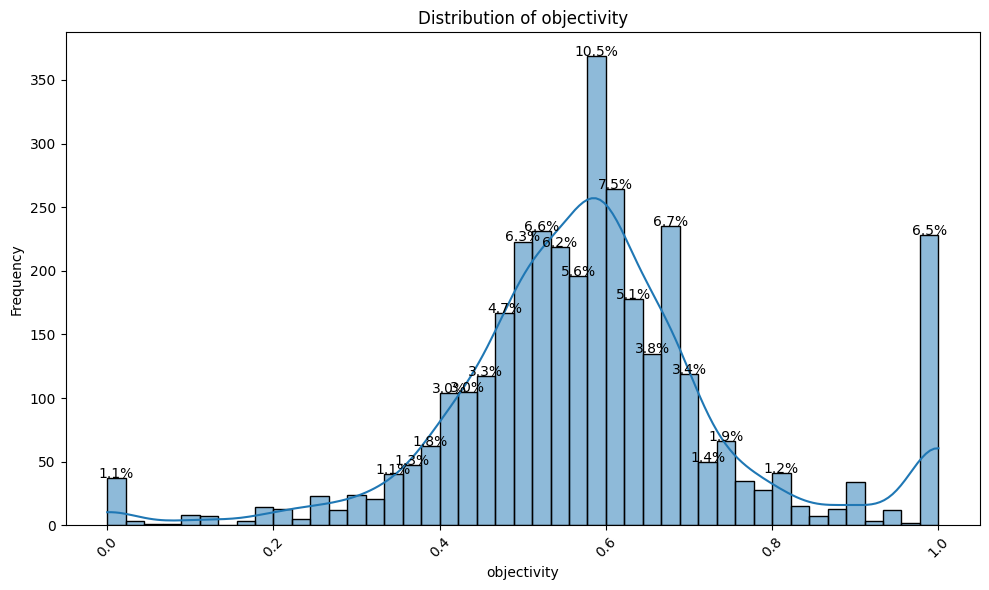

Statistics for objectivity:
count    3517.000000
mean        0.586878
std         0.175250
min         0.000000
25%         0.497662
50%         0.584690
75%         0.666667
max         1.000000
Name: objectivity, dtype: float64


In [ ]:
plot_column_distribution(conf_df, 'objectivity', top_k=20, figsize=(10, 6), kde=True)

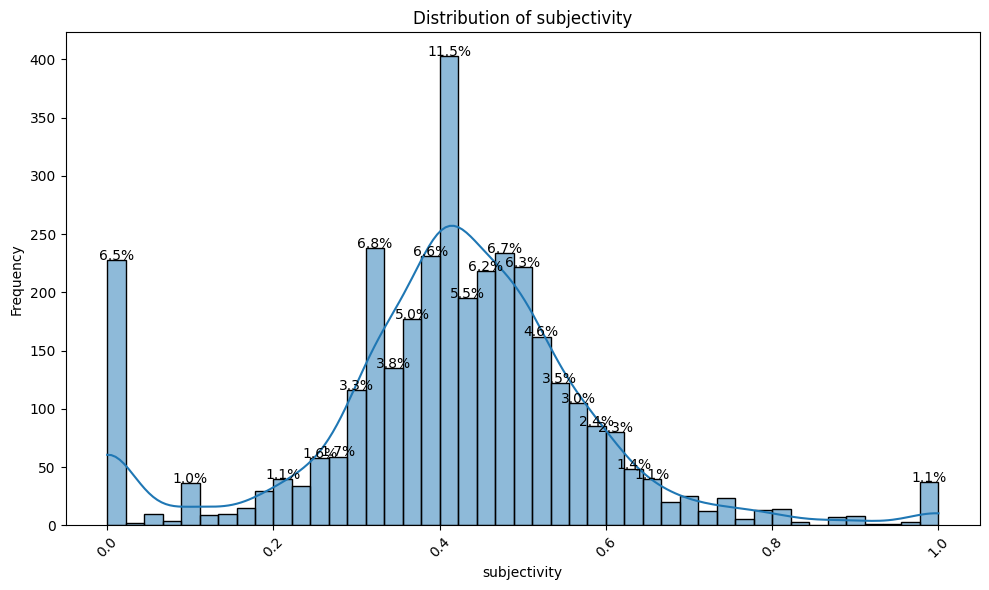

Statistics for subjectivity:
count    3517.000000
mean        0.413122
std         0.175250
min         0.000000
25%         0.333333
50%         0.415310
75%         0.502338
max         1.000000
Name: subjectivity, dtype: float64


In [ ]:
plot_column_distribution(conf_df, 'subjectivity', top_k=20, figsize=(10, 6), kde=True)

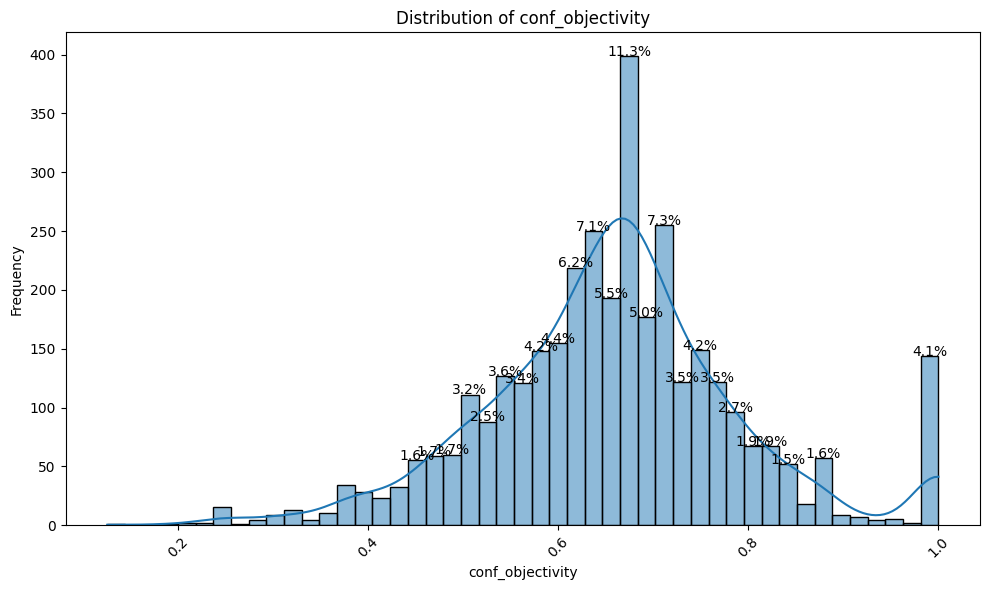

Statistics for conf_objectivity:
count    3517.000000
mean        0.658665
std         0.135192
min         0.125000
25%         0.581667
50%         0.664386
75%         0.725000
max         1.000000
Name: conf_objectivity, dtype: float64


In [ ]:
plot_column_distribution(conf_df, 'conf_objectivity', top_k=20, figsize=(10, 6), kde=True)

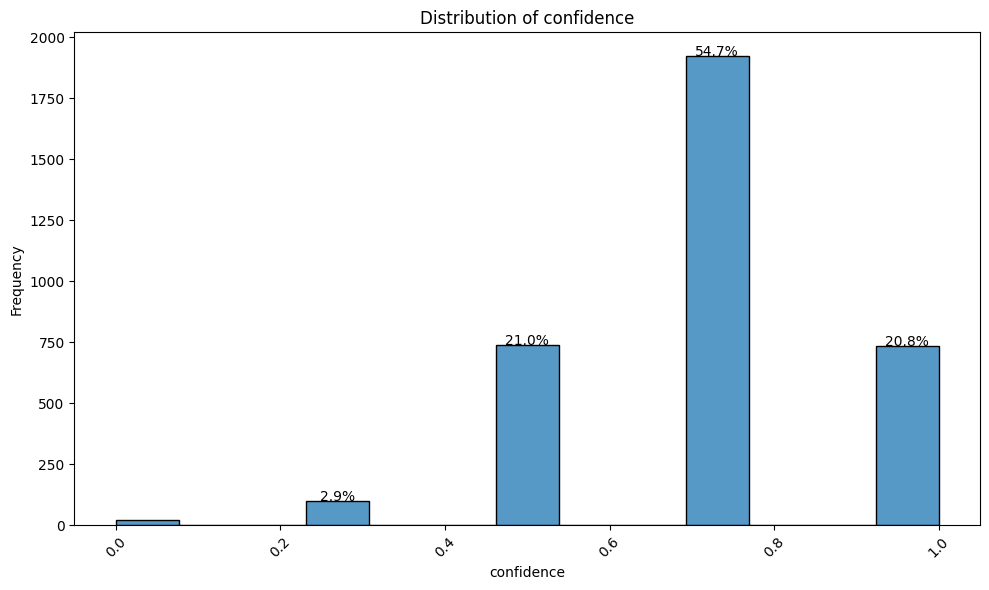

Statistics for confidence:
count    3517.000000
mean        0.730452
std         0.191336
min         0.000000
25%         0.750000
50%         0.750000
75%         0.750000
max         1.000000
Name: confidence, dtype: float64


In [ ]:
plot_column_distribution(conf_df, 'confidence', top_k=20, figsize=(10, 6), kde=False)

In [ ]:
mean_conf_subj = conf_df.groupby('confidence')['subjectivity'].mean()
mean_conf_subj

,subjectivity
confidence,
0.00,0.316831
0.25,0.413391
0.50,0.424142
0.75,0.430394
1.00,0.359714


## OpenReview

In [ ]:
or_main_df

,review_id,paper_id,raw_review,year,venue,paper_title,paper_authors,paper_abstract,paper_keywords,forum_url,pdf_url,review_url,structured_review
0,ryhZ3-M4l,HkwoSDPgg,"{""title"": ""Nice paper, strong accept"", ""rating...",2017,ICLR.cc/2017/conference,Semi-supervised Knowledge Transfer for Deep Le...,"[""Nicolas Papernot"", ""Mart\u00edn Abadi"", ""\u0...",Some machine learning applications involve tra...,"[""student"", ""model"", ""teachers"", ""knowledge tr...",https://openreview.net/forum?id=HkwoSDPgg,https://openreview.net/pdf?id=HkwoSDPgg,https://openreview.net/forum?id=HkwoSDPgg&note...,"{'idea_max_rating_guess': 10.0, 'idea_only_rev..."
1,HJyf86bNx,HkwoSDPgg,"{""title"": ""A nice contribution to differential...",2017,ICLR.cc/2017/conference,Semi-supervised Knowledge Transfer for Deep Le...,"[""Nicolas Papernot"", ""Mart\u00edn Abadi"", ""\u0...",Some machine learning applications involve tra...,"[""student"", ""model"", ""teachers"", ""knowledge tr...",https://openreview.net/forum?id=HkwoSDPgg,https://openreview.net/pdf?id=HkwoSDPgg,https://openreview.net/forum?id=HkwoSDPgg&note...,"{'idea_max_rating_guess': 10.0, 'idea_only_rev..."
2,HJNWD6Z4l,HkwoSDPgg,"{""title"": ""Good theory"", ""rating"": ""7: Good pa...",2017,ICLR.cc/2017/conference,Semi-supervised Knowledge Transfer for Deep Le...,"[""Nicolas Papernot"", ""Mart\u00edn Abadi"", ""\u0...",Some machine learning applications involve tra...,"[""student"", ""model"", ""teachers"", ""knowledge tr...",https://openreview.net/forum?id=HkwoSDPgg,https://openreview.net/pdf?id=HkwoSDPgg,https://openreview.net/forum?id=HkwoSDPgg&note...,"{'idea_max_rating_guess': 10.0, 'idea_only_rev..."
3,BybRJGfNl,SyOvg6jxx,"{""title"": ""Solid paper"", ""rating"": ""7: Good pa...",2017,ICLR.cc/2017/conference,#Exploration: A Study of Count-Based Explorati...,"[""Haoran Tang"", ""Rein Houthooft"", ""Davis Foote...",Count-based exploration algorithms are known t...,"[""Deep learning"", ""Reinforcement Learning"", ""G...",https://openreview.net/forum?id=SyOvg6jxx,https://openreview.net/pdf?id=SyOvg6jxx,https://openreview.net/forum?id=SyOvg6jxx&note...,"{'idea_max_rating_guess': 10.0, 'idea_only_rev..."
4,BJX3nErVg,SyOvg6jxx,"{""title"": ""Final review: significant results i...",2017,ICLR.cc/2017/conference,#Exploration: A Study of Count-Based Explorati...,"[""Haoran Tang"", ""Rein Houthooft"", ""Davis Foote...",Count-based exploration algorithms are known t...,"[""Deep learning"", ""Reinforcement Learning"", ""G...",https://openreview.net/forum?id=SyOvg6jxx,https://openreview.net/pdf?id=SyOvg6jxx,https://openreview.net/forum?id=SyOvg6jxx&note...,"{'idea_max_rating_guess': 5.0, 'idea_only_revi..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98119,Q-Kz-5gCR64,rMSlLb33Gb,"{""title"": ""Paper shows the efficacy of indirec...",2023,KDD.org/2023/Workshop/epiDAMIK,"A Snapshot of COVID-19 Incidence, Hospitalizat...","[""Juan Marcos Ramirez"", ""Sergio Diaz-Aranda"", ...",The estimation of incidence has been a crucial...,"[""COVID-19"", ""incidence estimation"", ""indirect...",https://openreview.net/forum?id=rMSlLb33Gb,https://openreview.net/pdf?id=rMSlLb33Gb,https://openreview.net/forum?id=rMSlLb33Gb&not...,"{'idea_max_rating_guess': 5.0, 'idea_only_revi..."
98120,i7lQlnCLyYO,rMSlLb33Gb,"{""title"": ""Paper provides a succinct and acces...",2023,KDD.org/2023/Workshop/epiDAMIK,"A Snapshot of COVID-19 Incidence, Hospitalizat...","[""Juan Marcos Ramirez"", ""Sergio Diaz-Aranda"", ...",The estimation of incidence has been a crucial...,"[""COVID-19"", ""incidence estimation"", ""indirect...",https://openreview.net/forum?id=rMSlLb33Gb,https://openreview.net/pdf?id=rMSlLb33Gb,https://openreview.net/forum?id=rMSlLb33Gb&not...,"{'idea_max_rating_guess': 5.0, 'idea_only_revi..."
98121,bXQdGqYlDN,rMSlLb33Gb,"{""title"": ""Review of a Paper on Estimating COV...",2023,KDD.org/2023/Workshop/epiDAMIK,"A Snapshot of COVID-19 Incidence, Hospitalizat...","[""Juan Marcos Ramirez"", ""Sergio Diaz-Aranda"",

In [ ]:
sentiments = np.empty(len(or_main_df), dtype=float)
sentiments.fill(np.nan)  # Fill with NaN as default

# Iterate through each text and calculate sentiment
for i, text in enumerate(or_main_df['raw_review']):
    # Skip NaN values (NaN will remain in those positions)
    if pd.isna(text):
        continue

    # Calculate sentiment and store in the NumPy array
    sentiment = TextBlob(text).sentiment.polarity
    sentiments[i] = sentiment

In [ ]:
global_sentiment_mean = np.mean(sentiments)
global_sentiment_mean

0.10649169296868881

In [ ]:
np.std(sentiments)

0.06572455711776054

In [ ]:
np.median(sentiments)

0.10224781958237839

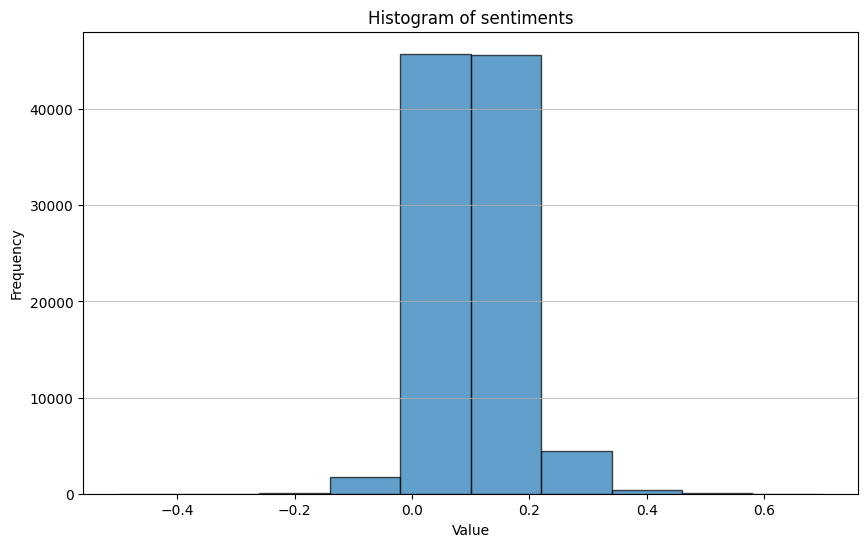

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(sentiments, bins=10, edgecolor='black', alpha=0.7)

# Add title and labels
plt.title('Histogram of sentiments')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Add grid
plt.grid(axis='y', alpha=0.75)

# Display the histogram
plt.show()

# Feature Engineering

In [ ]:
def merge_dataframes(origin_df, sample_df):
    """
    Performs an inner join between origin_df and sample_df using 'pid'
    from origin_df and 'review_of' from sample_df.

    Parameters:
    - origin_df: pandas DataFrame containing a 'pid' column.
    - sample_df: pandas DataFrame containing a 'review_of' column.

    Returns:
    - merged_df: Resulting DataFrame after the merge.
    """
    merged_df = pd.merge(origin_df, sample_df, how='inner', left_on='pid', right_on='review_of')
    return merged_df

## Feature 1: Proxy Impact Factor Index

In [ ]:
def calculate_word_count_stats(string_list):
    """
    Calculate word count statistics for a list of strings.

    Args:
        string_list: List of strings to analyze

    Returns:
        tuple: (mean, median, std) of word counts
    """
    # Skip empty strings
    valid_strings = [text for text in string_list if text]

    if not valid_strings:
        return 0, 0, 0

    # Count words in each string
    word_counts = np.array([len(text.split()) for text in valid_strings])

    # Calculate statistics
    mean_word_count = np.mean(word_counts)
    median_word_count = np.median(word_counts)
    std_word_count = np.std(word_counts)

    return mean_word_count, median_word_count, std_word_count

# Example usage
texts = [
    "This is a sample text with some words of varying length.",  # 10 words
    "Short words are common in English.",                       # 6 words
    "Pneumonoultramicroscopicsilicovolcanoconiosis is a very long word."  # 6 words
]

mean, median, std = calculate_word_count_stats(texts)
print(f"Mean word count: {mean:.2f} words")
print(f"Median word count: {median:.2f} words")
print(f"Standard deviation: {std:.2f} words")

Mean word count: 7.67 words
Median word count: 6.00 words
Standard deviation: 2.36 words


In [ ]:
def find_closest_row(df, target_values, columns=None):
    """
    Find the row in a DataFrame that is closest to the target values.

    Args:
        df: pandas DataFrame
        target_values: tuple of values to match (in order of columns)
        columns: list of column names to compare (defaults to first n columns)

    Returns:
        pandas Series: The row closest to the target values
    """
    # If columns not specified, use the first n columns where n is the length of target_values
    if columns is None:
        columns = df.columns[:len(target_values)]

    # Ensure we have the right number of columns
    if len(columns) != len(target_values):
        raise ValueError("Number of target values must match number of columns")

    # Extract the columns we want to compare
    df_subset = df[columns]

    # Create a DataFrame with just one row containing our target values
    target_df = pd.DataFrame([target_values], columns=columns)

    # Calculate Euclidean distance for each row
    distances = np.sqrt(((df_subset - target_df.iloc[0]) ** 2).sum(axis=1))

    # Find the index of the minimum distance
    closest_index = distances.idxmin()

    return df.iloc[closest_index]

target = (7.67, 6.00, 2.36)
closest_row =find_closest_row(stats_df, target, columns=['mean', 'median', 'std'])
print(closest_row)

reviewer_country       Burma
count                     14
mean                9.928571
median                   9.0
std                 4.269107
min                        7
max                       22
25%                      7.5
75%                      9.0
IQR                      1.5
skew                2.313527
kurtosis            5.014218
Name: 114, dtype: object


In [ ]:
country_IF['Burma']

0.4859010679655034

In [ ]:
def proxy_IF(sample_df):
    reviews = sample_df['review'].to_list()
    mean_word_count, median_word_count, std_word_count = calculate_word_count_stats(reviews)
    closest_row = find_closest_row(stats_df, (mean_word_count, median_word_count, std_word_count), columns=['mean', 'median', 'std'])
    country = closest_row['reviewer_country']
    print('closest IF to:', country)
    return country_IF[country]
proxy_IF(sample)

closest IF to: Slovakia


0.32877612534478345

## Feature 2: Acceptence/Rejection Ratio

In [ ]:
def compute_decision_ratio(RD_df, sample_df):
    # Perform an inner merge on origin_df and sample_df using 'pid' and 'review_of' as keys
    # merged_df = pd.merge(origin_df, sample_df, how='inner', left_on='pid', right_on='review_of')
    sample_df = merge_dataframes(RD_df, sample_df)
    # Drop duplicates based on 'pid', keeping the first occurrence
    sample_df = sample_df.drop_duplicates(subset=['pid'], keep='first')

    # Get the counts of each decision value
    value_counts = sample_df['decision'].value_counts()

    # Calculate the ratio of decision==1 over the total count
    ratio = value_counts.get(1, 0) / value_counts.sum()

    return ratio

In [ ]:
compute_decision_ratio(RD_df, sample)

0.43333333333333335

## Feature 3: Chutzpah (Audacity)

In [ ]:
def compute_audacity(RD_df, sample_df, quantile=0.7):
    df = merge_dataframes(RD_df, sample_df)
    df = df[df['h_index'] >= RD_df['h_index'].quantile(quantile)]
    return compute_decision_ratio(df, sample_df)

In [ ]:
compute_audacity(RD_df, sample, quantile=0.7)

0.5

## Feature 4: Objectivity Confidence

In [ ]:
mean_global_confidence = 0.730452
mean_global_objectivity = 0.586878

In [ ]:
def compute_objectivity_confidence(RD_df, sample_df, mean_global_confidence, mean_global_objectivity):
    df = merge_dataframes(RD_df, sample_df)
    df = df[['review','confidence']]
    df['subjectivity'] = df['review'].apply(lambda text: TextBlob(text).sentiment.subjectivity)
    df['conf_objectivity'] = ((df['confidence']/mean_global_confidence) + (1 - df['subjectivity'])/mean_global_objectivity) / 2
    df['conf_objectivity'] = (df['conf_objectivity'] - df['conf_objectivity'].min()) / (df['conf_objectivity'].max() - df['conf_objectivity'].min())
    return df['conf_objectivity'].mean()

compute_objectivity_confidence(RD_df, sample, mean_global_confidence, mean_global_objectivity)

0.3837974718664309

## Feature 5: Sentiment Ratio

In [ ]:
mean_global_sentiment = 0.10649169296868881
std_global_sentiment = 0.06572455711776054

In [ ]:
def compute_sentiment_ratio(sample_df, mean_global_sentiment, std_global_sentiment):
    sentiments = np.empty(len(sample_df), dtype=float)
    sentiments.fill(np.nan)  # Fill with NaN as default

    # Iterate through each text and calculate sentiment
    for i, text in enumerate(sample_df['review']):
        # Skip NaN values (NaN will remain in those positions)
        if pd.isna(text):
            continue

        # Calculate sentiment and store in the NumPy array
        sentiment = TextBlob(text).sentiment.polarity
        sentiments[i] = sentiment

    return np.mean(sentiments)
compute_sentiment_ratio(sample, mean_global_sentiment, std_global_sentiment)

0.10237831510157563

# Analysis

In [ ]:
sample = pd.read_csv('/content/drive/MyDrive/BD PROJECT/DATA/sampled_reviews.csv')

In [ ]:
sample

,rid,review_of,title,review,rating,confidence,raw_rating,raw_confidence
0,3930,B1CNpYg0-,Review,This paper describes a method for computing re...,0.444444,0.75,5: Marginally below acceptance threshold,4: The reviewer is confident but not absolutel...
1,5257,HJNcU0VYx,Review,Summary: This paper proposed two techniques to...,0.555556,1.00,6: Marginally above acceptance threshold,5: The reviewer is absolutely certain that the...
2,6119,rJq_YBqxx,Well-executed paper with good analysis but lit...,Update after reading the authors' responses & ...,0.444444,1.00,5: Marginally below acceptance threshold,5: The reviewer is absolutely certain that the...
3,5363,r1PyAP4Yl,NaN,Even though I enjoy the main idea of concatena...,0.333333,0.75,4: Ok but not good enough - rejection,4: The reviewer is confident but not absolutel...
4,1833,rJY7hoi8z,A generative model of small graphs with a deep...,The paper considers the problem of learning to...,0.666667,0.50,"7: Good paper, accept",3: The reviewer is fairly confident that the e...
5,4978,rywDjg-RW,Incremental paper but well-written,"This paper extends and speeds up PROSE, a prog...",0.555556,0.50,6: Marginally above acceptance threshold,3: The reviewer is fairly confident that the e...
6,3491,S1LXVnxRb,Review,SUMMARY.\n\nThe paper presents a cross-corpus ...,0.333333,0.75,4: Ok but not good enough - rejection,4: The reviewer is confident but not absolutel...
7,4325,SJyEH91A-,An efficient approach to compute Wasserstein d...,The paper proposes to use a deep neural networ...,0.666667,0.50,"7: Good paper, accept",3: The reviewer is fairly confident that the e...
8,6511,HJgXCV9xx,Review,\nSUMMARY: This paper describes a set of exper...,0.444444,0.75,5: Marginally below acceptance threshold,4: The reviewer is confident but not absolutel...
9,625,S1x7WjnzdV,An Interesting Analysis of Coordinate Tiled VA...,Summary: the authors present a simple extensio...,0.600000,1.00,3: Marginally above acceptance threshold,3: The reviewer is absolutely certain that the...


In [ ]:
Feature_1 = proxy_IF(sample)
Feature_1

closest IF to: Slovakia


0.32877612534478345

In [ ]:
Feature_2 = compute_decision_ratio(RD_df, sample)
Feature_2

0.43333333333333335

In [ ]:
Feature_3 = compute_audacity(RD_df, sample, quantile=0.7)
Feature_3

0.5

In [ ]:
Feature_4 = compute_objectivity_confidence(RD_df, sample, mean_global_confidence, mean_global_objectivity)
Feature_4

0.3837974718664309

In [ ]:
Feature_5 = compute_sentiment_ratio(sample, mean_global_sentiment, std_global_sentiment)
Feature_5

0.10237831510157563

In [ ]:
Features = [Feature_1, Feature_2, Feature_3, Feature_4, Feature_5]

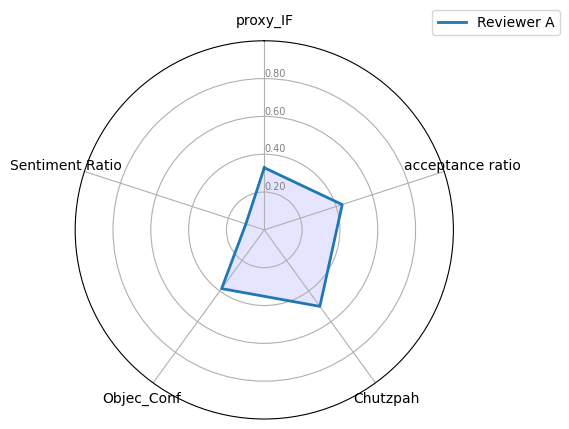

In [ ]:
# Define features and their placeholder values
features = ["proxy_IF", "acceptance ratio", "Chutzpah", "Objec_Conf", "Sentiment Ratio"]
N = len(features)

# Example values for each feature (placeholder values)
values = Features

# Radar charts are circular, so we repeat the first value at the end.
values += values[:1]

# Compute the angle for each axis in the plot
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # close the polygon

# Create a subplot with polar coordinates
fig, ax = plt.subplots(subplot_kw={"polar": True}, figsize=(6, 6))

# Set offset and direction for the radial axes
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw one axis per variable and label
plt.xticks(angles[:-1], features)

# Define radial (y-axis) limits and label positions
ax.set_rlabel_position(0)
plt.yticks([0.20, 0.40, 0.60, 0.80], ["0.20", "0.40", "0.60", "0.80"], color="gray", size=7)
plt.ylim(0, 1)

# Plot data
ax.plot(angles, values, linewidth=2, linestyle='solid', label="Reviewer A")
ax.fill(angles, values, 'b', alpha=0.1)  # fill area

# Optional legend
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Title and show the radar chart

plt.tight_layout()
plt.show()